In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import more_itertools as mit
import urllib
%matplotlib inline  


In [2]:
def histograma(dataset, numero_bins=50, type_bins='log'):
    """
    Calcula el histograma de una serie de datos y guarda el resultado
    El input es una lista, no sirve meter como input un histograma X-Y
    INPUT:
        dataset (list, array): Datos sobre los que se hacen el histograma
        header (str): String for using in header and in file name
        output_path (str): Donde se guardara el resultado. IF OUTPUT_PATH=FALSE
                            devuelve el histograma y no lo guarda a archivo
        numero_bins (int): Numero de bins que se realizaran
        type_bins ('log', 'lin'): Relacion para generar los bins
        output_name (str): Name for the output file with extension .txt
        header_adicional (str): Aditional header info only for the file header
    OUTPUT:
        Guarda el resultado en output_path
        if output_path == FALSE: Devuelve bin_mean_x, counts_mean
    """

    dataset = np.asarray(dataset)

    # Defining edges depending if log or lin
    if (type_bins == 'log'):
        min_x = np.log10(np.min(dataset[dataset.nonzero()]))
        max_x = np.log10(np.max(dataset))
        bin_edges = np.logspace(min_x, max_x, numero_bins)
        
    elif (type_bins == 'lin'):
        min_x = np.min(dataset[dataset.nonzero()])
        max_x = np.max(dataset)
        bin_edges = np.linspace(min_x, max_x, numero_bins)

    # En que bin cae cada dato
    index = np.digitize(dataset, bin_edges)

    # Frecuencia de datos por bin
    datosPorBin = [len(dataset[index == i]) for i in range(1, len(bin_edges))]

    # Adimensionaliza la frecuencia por la anchura del bin
    counts_mean = datosPorBin/np.diff(bin_edges)
    counts_mean = counts_mean[counts_mean != 0]
    
    # version normalizada
    masatotal = np.sum(datosPorBin)
    counts_norm = counts_mean/masatotal

    # Posicion media del eje x
    bin_mean_x = [dataset[index == i].mean() for i in range(1, len(bin_edges))
                  if len(np.asarray(dataset[index == i])) > 0]

    return(bin_mean_x, counts_mean, counts_norm, bin_edges)

In [3]:
def binear_datos(lista_x, lista_y, bins=50, log = True):
    """
    Dado una lista de par de puntos (X,Y) binea dando lugar a una lista equivalente
    pero de menor dimension. Sirve para eliminar el ruido, variaciones, etc.
    INPUT:
        lista_x (list, array): Lista de puntos de igual dimension que lista_y
        lista_y (list, array): Lista de puntos de igual dimension que lista_x
        bins (int): numero de bins a utilizar
        log (boolean): True-> bins logaritmico, False-> bins lineales
    OUTPUT:
        posiciones (array): Centro de gravedad del bin. lista de posiciones X
        frecuencia_media(array): Frecuencia pesada en los bins
    """
    # Definicion de los bins
    if log:
        bin_edges = np.logspace(np.log10(min(lista_x)), np.log10(max(lista_x)), bins)
    else:
         bin_edges = np.linspace(min(lista_x), max(lista_x), bins)

    diccionario = dict() # valor*posicion
    diccionario_frecs = dict()
    for indice_x, value_x in enumerate(lista_x):
        indice_caja = np.searchsorted(bin_edges, value_x)
        if indice_caja in diccionario:
            diccionario[indice_caja].append(lista_x[indice_x]*lista_y[indice_x])
            diccionario_frecs[indice_caja].append(lista_y[indice_x])
        else:
            diccionario[indice_caja] = list()
            diccionario_frecs[indice_caja] = list()
            diccionario[indice_caja].append(lista_x[indice_x]*lista_y[indice_x])
            diccionario_frecs[indice_caja].append(lista_y[indice_x])

    frecuencia_media = []
    for key, value in diccionario_frecs.items():
        if len(value) > 0:
            frecuencia_media.append(np.mean(value))

        elif len(value) == 0:
            frecuencia_media.append(0)

    posiciones = []
    for key, value in diccionario.items():
        if len(value) > 0:
            posiciones.append(np.sum(value)/np.sum(diccionario_frecs[key]))
        elif len(value) == 0:
            posiciones.append((bin_edges[key] + bin_edges[key+1])/2)
            
    ## Ordenamos los datos
    import pandas as pd
    df = pd.DataFrame({"pos": posiciones, "freqs": frecuencia_media})
    df = df.sort_values("pos")

    posiciones = df.pos.values
    frecuencia_media = df.freqs.values
    
    return posiciones, frecuencia_media

In [4]:
def add_subplot_axes(ax, rect, fig, axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg, xscale = 'log', yscale ='log')
    #subax.xaxis.tick_top()
    subax.xaxis.set_label_position('bottom') 
    #subax.yaxis.tick_right()
    subax.yaxis.set_label_position('left')
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return(subax)

In [5]:
# Comment for debugging
import warnings
warnings.filterwarnings('ignore')

# Calcula las figuras de linguistic laws in human comunication
REQUISITO: Tener una tabla con las duraciones de cada fonema, palabra, etc


In [6]:
# Post processed data
#url = 'https://datadryad.org/bitstream/handle/10255/dryad.222397/TablaTranscripcion.csv?sequence=1'  
#urllib.request.urlretrieve(url, "./TablaTranscripcion.csv")  

# 1. Cargar datos

In [7]:
input_path = 'TablaTranscripcion.csv'

# Cargar datos
tabla_datos = pd.read_csv(input_path, delimiter=",", skiprows=2, 
                            names=['token', 'tinit', 'tend', 'duration', 'sentence', 'path', 'tipe', 'numtoken', 'numphonemes',
                                  'numletters'])
# Para recuperar los okeys
#tabla_datos[tabla_datos.numtoken.isin(tabla_datos[tabla_datos.token == "okay"].numtoken)]
tabla_datos.head()

,token,tinit,tend,duration,sentence,path,tipe,numtoken,numphonemes,numletters
0,okay,32.216575,32.622045,0.405470,2,s01/s0101a/,w,1,2,4
1,k,32.216575,32.376593,0.160018,2,s01/s0101a/,p,1,1,1
2,ay,32.376593,32.622045,0.245452,2,s01/s0101a/,p,1,1,2
3,um,44.617996,44.946848,0.328852,5,s01/s0101a/,w,2,2,2
4,ah,44.617996,44.820731,0.202735,5,s01/s0101a/,p,2,1,2


In [8]:
# Filtramos y nos quedamos solo con palabras
lista_words = tabla_datos[((tabla_datos.tipe == 'w') & (tabla_datos.token != 'SIL')
                           & (tabla_datos.token != 'VOCNOISE') & (tabla_datos.token != 'UNKNOWN') 
                           & (tabla_datos.token != 'NOISE') & (tabla_datos.token != 'LAUGH'))]

# Creamos una columna que indique el numero de caracteres de esa palabra
lista_words = lista_words.assign(dur_characteres=lista_words.token.str.len())

In [9]:
# Filtramos y nos quedamos solo con fonemas
lista_fonema = tabla_datos[((tabla_datos.tipe == 'p') & (tabla_datos.token != 'SIL') & (tabla_datos.token != 'VOCNOISE') 
                            & (tabla_datos.token != 'UNKNOWN') & (tabla_datos.token != 'NOISE') & (tabla_datos.token != 'LAUGH')
                            & (tabla_datos.token != 'IVER')
                            & (tabla_datos.token.str.endswith("}") == False) & (tabla_datos.token.str.startswith("{") == False))]

In [10]:
# Obtenemos las duraciones de las frases
dur_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().duration
# print(lista_fonema.token.unique())
# print(len(lista_fonema.token.unique()))
# tabla_datos[tabla_datos.token == "the"].head()
# tabla_datos[tabla_datos.numtoken == 131]

# Obtener las tablas 1 y 2


In [11]:
from statistics import mode

def imprimir_estadistica(listaduration, rnd, string):
    
    phonN = len(listaduration)
    phonMean = np.round(np.mean(listaduration), rnd)
    phonStd = np.round(np.std(listaduration), rnd)
    phonMode = mode(np.round(listaduration, rnd))
    phonMedian = np.round(np.median(listaduration), rnd)
    phonP10 = np.round(np.percentile(listaduration, 10), rnd)
    phonP90 = np.round(np.percentile(listaduration, 90), rnd)
    print(string + str(phonN) +"  "+ str(phonMean) + "  " + str(phonStd) +
      "  " + str(phonMode) + "  " + str(phonMedian) + "  " + str(phonP10) +
     "  " + str(phonP90))

print("                    Time Duration (s)")
print("           n     Mean  Std  Mode  Median  p10  p90")

imprimir_estadistica(lista_fonema.duration, 2, "Phoneme:   ")
imprimir_estadistica(lista_words.duration, 2, "Word:      ")
imprimir_estadistica(dur_sentences, 1, "BG:          ")


                    Time Duration (s)
           n     Mean  Std  Mode  Median  p10  p90
Phoneme:   796172  0.08  0.06  0.05  0.07  0.03  0.14
Word:      269565  0.24  0.17  0.12  0.2  0.08  0.45
BG:          45034  1.4  1.2  0.4  1.1  0.3  3.1


In [12]:
def imprimir_estadistica(listaduration, rnd, string):
    
    phonMean = np.round(np.mean(listaduration), rnd)
    phonStd = np.round(np.std(listaduration), rnd)
    phonMode = mode(np.round(listaduration, rnd))
    phonMedian = np.round(np.median(listaduration), rnd)
    phonP10 = np.round(np.percentile(listaduration, 10), rnd)
    phonP90 = np.round(np.percentile(listaduration, 90), rnd)
    print(string + str(phonMean) + "  " + str(phonStd) +
      "  " + str(phonMode) + "  " + str(phonMedian) + "  " + str(phonP10) +
     "  " + str(phonP90))

print("                    Num Characters")
print("         Mean Std  Mode  Median p10 p90")

numcharperphoneme = lista_words.numletters/lista_words.numphonemes
numcharperphoneme = numcharperphoneme[numcharperphoneme<7]

imprimir_estadistica(numcharperphoneme, 1, "Phoneme:   ")
imprimir_estadistica(lista_words.numletters, 0, "Word:      ")
char_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().numletters
imprimir_estadistica(char_sentences, 0, "BG:       ")

print("")
print("                    Num Phonemas")
imprimir_estadistica(lista_words.numphonemes, 1, "Word:      ")
phon_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().numphonemes
imprimir_estadistica(phon_sentences, 0, "BG:      ")

print("")
print("                    Num Words")
words_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").count().numphonemes
imprimir_estadistica(words_sentences, 0, "BG:      ")


                    Num Characters
         Mean Std  Mode  Median p10 p90
Phoneme:   1.4  0.5  1.0  1.3  1.0  2.0
Word:      4.0  2.0  4  4.0  2.0  7.0
BG:       24.0  23.0  2  17.0  3.0  54.0

                    Num Phonemas
Word:      3.0  1.6  2  3.0  1.0  5.0
BG:      18.0  17.0  2  13.0  2.0  40.0

                    Num Words
BG:      6.0  6.0  1  4.0  1.0  13.0


In [13]:
# EJEMPLO DE LA FRASE Más LARGA
#a = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").size()
#frase = a[a==a.max()].index[0]

#tabla_datos[(tabla_datos.sentence == frase) & (tabla_datos.tipe == "w")]


In [14]:
# # EJEMPLO DE LA FRASE Mas corta
# # Obtenemos las duraciones de las frases
# frases1palabra = tabla_datos[(tabla_datos.tipe == "w")].groupby("sentence").size()
# frases1palabra = frases1palabra[frases1palabra==1].index

# subset = tabla_datos[tabla_datos['sentence'].isin(np.array(frases1palabra))]
# subset[(subset.tipe == "w") & (subset.duration < 0.15)]
#subset.groupby("sentence").size()
#a = .groupby("sentence").size()
#a = tabla_datos[(tabla_datos.tipe == "w")].groupby("sentence").size()
#frase = a[a==1]
#frase

#tabla_datos[(tabla_datos.sentence == frase) & (tabla_datos.tipe == "w")]


# 2. Histograma duraciones fonemas, palabras, frases y colapso

Calculamos los histogramas de duraciones en segundos

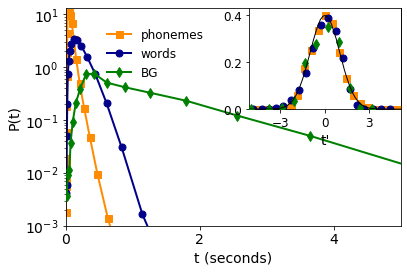

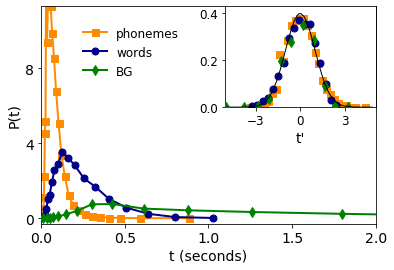

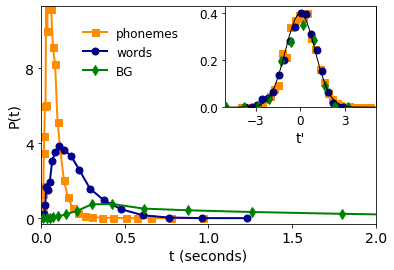

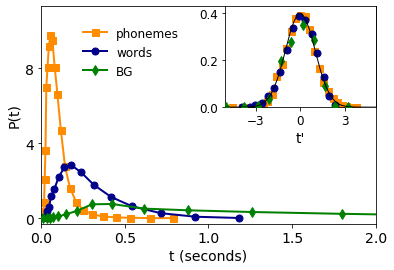

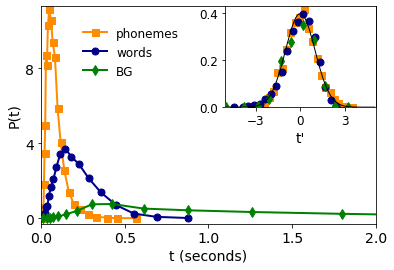

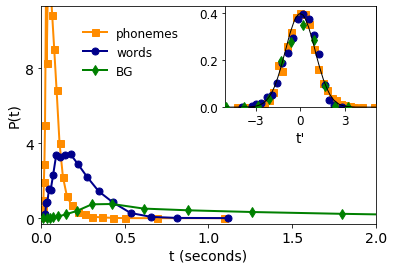

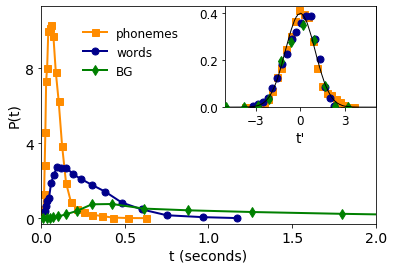

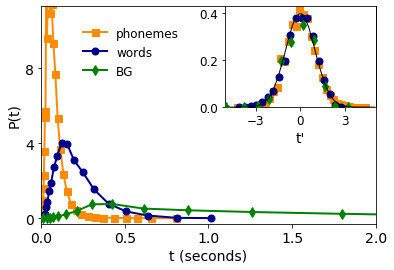

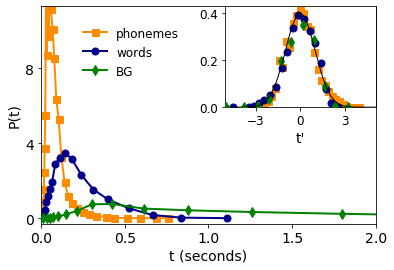

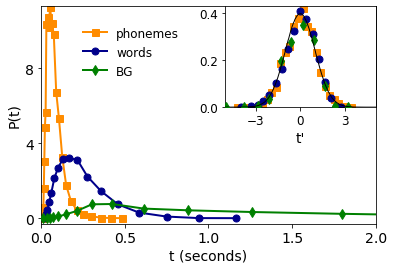

In [15]:

# Definimos adecuadamente el subconjunto de fonemas y palabras
fonemes_durationsall = lista_fonema.duration.values[(lista_fonema.duration.values<5) & (lista_fonema.duration.values>0)]
words_durationsall = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]
dur_sentencesall = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().duration

listainformant = ["s01/", "s02/", "s03/", "s04/", "s05/", "s06/", "s07/", "s08/", "s09/"]

for i in range(10):
    if i == 0:
        fonemes_durations = fonemes_durationsall
        words_durations = words_durationsall
        dur_sentences = dur_sentencesall

    else:
        lista_fonema2 = lista_fonema[lista_fonema.path.str.startswith(listainformant[i-1])]
        fonemes_durations2 = lista_fonema2.duration.values[(lista_fonema2.duration.values<5) & (lista_fonema2.duration.values>0)]

        lista_words2 = lista_words[lista_words.path.str.startswith(listainformant[i-1])]
        words_durations2 = lista_words2.duration.values[(lista_words2.duration.values<5) & (lista_words2.duration.values>0) ]

        tabla_datos2 = tabla_datos[tabla_datos.path.str.startswith(listainformant[i-1])]
        dur_sentences2 = tabla_datos2[tabla_datos2.tipe == "w"].groupby("sentence").sum().duration
                       
        fonemes_durations = fonemes_durations2
        words_durations = words_durations2
        #dur_sentences = dur_sentences2


    # Realizamos los histogramas
    bin_mean_x_fon, _, counts_norm_fon, _ = histograma(fonemes_durations, numero_bins=35)
    bin_mean_x_word, _, counts_norm_word, _ = histograma(words_durations, numero_bins=20)
    bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=22)


    # Ploteamos
    f, ax = plt.subplots()
    ax.plot(bin_mean_x_fon, counts_norm_fon, '-s', lw = 2, ms = 7, label= 'phonemes', zorder=1, c="darkorange")
    ax.plot(bin_mean_x_word, counts_norm_word, '-o', lw = 2, ms = 7, label= 'words', zorder=2, c='darkblue')
    ax.plot(bin_mean_x_sentence, counts_norm_sentence, '-d', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")


    ax.set_ylim([-0.3, 11.3])
    ax.set_xlim([0, 2])

    ax.set_xlabel("t (seconds)", fontsize=14)
    ax.set_ylabel("P(t)", fontsize=14)

    # Table


    col_labels=[r'$<t>$',r'$mode$']
    row_labels=['phon','words','senten']
    table_vals=[[np.round(np.mean(lista_fonema.duration.values[lista_fonema.duration.values<4]),3),
                 scipy.stats.mode(np.round(lista_fonema.duration.values[lista_fonema.duration.values<4], 2))[0][0]],

                [np.round(np.mean(lista_words.duration.values[lista_words.duration.values<4]),2),
                 scipy.stats.mode(np.round(lista_words.duration.values[lista_words.duration.values<4], 2))[0][0]],

               [np.round(np.mean(dur_sentences), 1),
                   scipy.stats.mode(np.round(dur_sentences, 2))[0][0]]]


    ######################################
    ## COLAPSO DE LOS DATOS##############3
    # Vamos a intentar colapsar los datos
    log_fonemes_dur = np.log(fonemes_durations)
    log_fonemes_dur = (log_fonemes_dur - np.mean(log_fonemes_dur))/np.std(log_fonemes_dur)

    log_words_dur = np.log(words_durations)
    log_words_dur = (log_words_dur - np.mean(log_words_dur))/np.std(log_words_dur)

    log_sentences_dur = np.log(dur_sentences)
    log_sentences_dur = (log_sentences_dur - np.mean(log_sentences_dur))/np.std(log_sentences_dur)

    # Datos Normales 0,1
    randomNormal = np.random.normal(0, 1, 10000000)

    # Realizamos los histogramas
    bin_mean_x_fon_collapsed, _, counts_norm_fon_collapsed, _ = histograma(log_fonemes_dur, numero_bins=35, type_bins="lin")
    bin_mean_x_word_collapsed, _, counts_norm_word_collapsed, _ = histograma(log_words_dur, numero_bins=20, type_bins="lin")
    bin_mean_x_sentence_collapsed, _, counts_norm_sentence_collapsed, _ = histograma(log_sentences_dur, numero_bins=12, type_bins="lin")

    bin_mean_x_normal, _, counts_norm_normal, _ = histograma(randomNormal, numero_bins=200, type_bins="lin")


    # Ploteamos
    subax = plt.axes([0.55, 0.53, .35, .35])
    subax.plot(bin_mean_x_fon_collapsed, counts_norm_fon_collapsed, 's', lw = 2, ms = 7, label= 'phonemes', zorder=1, c="darkorange")
    subax.plot(bin_mean_x_word_collapsed, counts_norm_word_collapsed, 'o', lw = 2, ms = 7, label= 'words', zorder=2, c='darkblue')
    subax.plot(bin_mean_x_sentence_collapsed, counts_norm_sentence_collapsed, 'd', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")
    subax.plot(bin_mean_x_normal, counts_norm_normal, '-s', lw = 1, ms = 0, label= 'phonemes', zorder=5, c = 'k')


    subax.set_xlim([-5.1,5.1])
    subax.set_ylim([0, 0.43])
    subax.set_xticks([-3,0,3])
    subax.set_yticks([0, 0.2, 0.4])

    subax.set_xlabel("t'", fontsize=14)


    subax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xticks([0, 0.5, 1, 1.5, 2])
    ax.set_yticks([0, 4, 8])

    ax.legend(loc=(0.11, 0.65), frameon=False, fontsize = 12)


    if i == 0:
        f.savefig("1_Probability_distribution_duration.pdf")
        ax.set_yscale("log")
        ax.set_ylim([0.001, 13])
        ax.set_xlim([0, 5])
        ax.set_xticks([0, 2, 4])

        f.savefig("SI_LOG_1_Probability_distribution_duration.pdf")

    else:        
        f.savefig("1_Probability_distribution_duration_informant"+str(i)+".pdf", bbox_inches='tight')

        
##########################################
# Realizamos los histogramas
fonemes_durations = lista_fonema.duration.values[(lista_fonema.duration.values<5) & (lista_fonema.duration.values>0)]
words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]
dur_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().duration

bin_mean_x_fon, _, counts_norm_fon, _ = histograma(fonemes_durationsall, numero_bins=35)
bin_mean_x_word, _, counts_norm_word, _ = histograma(words_durationsall, numero_bins=20)
bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentencesall, numero_bins=22)

## 2.01. Modelo nulo duracion distribucion. MEAN FIELD MODEL


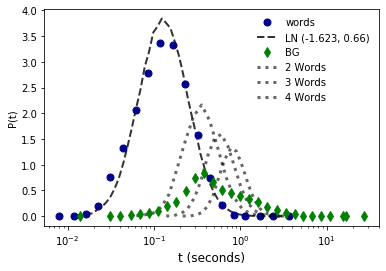

In [16]:
# FIGURA DEL SUPLEMENTARY INFORMATION 2

randLNWord = np.random.lognormal(mean=-1.623, sigma=0.66, size=200000)
bin_mean_x_word_rand, _, counts_norm_word_rand, _ = histograma(randLNWord, numero_bins=50, type_bins="log")

# WORDS
# MODELO LN
randSentence4 = [np.random.choice(randLNWord, 2).sum() for x in range(60000)]
bin_mean_x_randSentence4, _, counts_norm_randSentence4, _ = histograma(randSentence4, numero_bins=20, type_bins="log")

randSentence5 = [np.random.choice(randLNWord, 3).sum() for x in range(60000)]
bin_mean_x_randSentence5, _, counts_norm_randSentence5, _ = histograma(randSentence5, numero_bins=20, type_bins="log")

randSentence6 = [np.random.choice(randLNWord, 4).sum() for x in range(60000)]
bin_mean_x_randSentence6, _, counts_norm_randSentence6, _ = histograma(randSentence6, numero_bins=20, type_bins="log")


# MODELO ALEATORIO



# Ploteamos
f, ax = plt.subplots()
# WORDS REAL AND RANDOM
ax.plot(bin_mean_x_word, counts_norm_word, 'o', lw = 1, ms = 7, label= 'words', zorder=2, c='darkblue')
ax.plot(bin_mean_x_word_rand, counts_norm_word_rand, '--', lw = 2, ms = 1, label= 'LN (-1.623, 0.66)', zorder=1, c="k", alpha=0.8)

# BG REAL
bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=32)
ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")

# BG MODEL
ax.plot(bin_mean_x_randSentence4, counts_norm_randSentence4, ':', lw = 3, ms = 2, label= '2 Words', zorder=2, c="k", alpha=0.6)
ax.plot(bin_mean_x_randSentence5, counts_norm_randSentence5, ':', lw = 3, ms = 2, label= '3 Words', zorder=2, c="k", alpha=0.6)
ax.plot(bin_mean_x_randSentence6, counts_norm_randSentence6, ':', lw = 3, ms = 2, label= '4 Words', zorder=2, c="k", alpha=0.6)



ax.set_xscale("log")

#ax.set_ylim([0, 11.2])
#ax.set_xlim([0, 2])

ax.set_xlabel("t (seconds)", fontsize = 12)
ax.set_ylabel("P(t)")
ax.legend(loc="best", frameon=False)

f.savefig("SI:2_Mean_Field_model_words_BG.pdf")

## Mismo modelo nuevas 3 figuras

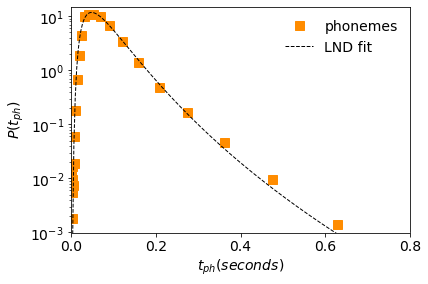

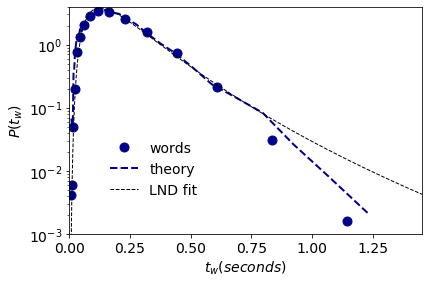

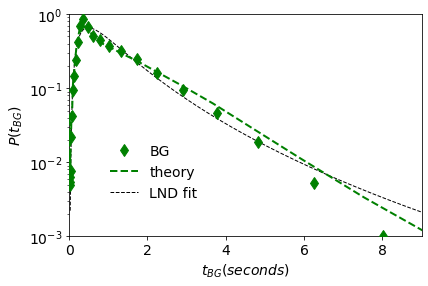

In [17]:
# RANDOM LN PHONEME GENERATION
randLNphonemes = np.random.lognormal(mean=-2.681, sigma=0.59, size=10000)
bin_mean_x_fon_rand, _, counts_norm_fon_rand, _ = histograma(randLNphonemes, numero_bins=60, type_bins="log")


# NUMERO DE PHONEMAS POR PALABRA
PhonemesPerWord = np.asarray(lista_words.numphonemes)

randWord = [np.random.choice(randLNphonemes, np.random.choice(PhonemesPerWord, 1)).sum() for x in range(10000)]#4
bin_mean_x_word_rand, _, counts_norm_word_rand, _ = histograma(randWord, numero_bins=35, type_bins="log")


# NUMERO DE PALABRAS POR FRASE
WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

randSentence = [np.random.choice(randWord, np.random.choice(WordsPerSentence, 1)).sum() for x in range(2000)]
bin_mean_x_sentence_rand, _, counts_norm_sentence_rand, _ = histograma(randSentence, numero_bins=30, type_bins="log")

bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=30)


# MODELO PALABRAS POR FRASE INCLUYENDO LA NORMAL
randSentenceNORMAL = [np.random.choice(randWord, np.random.choice(WordsPerSentence, 1)).sum() + np.random.normal(0.14, 0.08)  for x in range(30000)]
randSentenceNORMAL = np.asarray(randSentenceNORMAL)
randSentenceNORMAL = randSentenceNORMAL[randSentenceNORMAL>0.01]
bin_mean_x_sentence_randNORMAL, _, counts_norm_sentence_randNORMAL, _ = histograma(randSentenceNORMAL, numero_bins=30, type_bins="log")


################################################################################################
# # Ploteamos
f, ax = plt.subplots()

# # PHONEMES real and random
ax.plot(bin_mean_x_fon, counts_norm_fon, 's', lw = 1, ms = 9, label= 'phonemes', zorder=1, c="darkorange")
xlin = np.linspace(0, max(bin_mean_x_fon), 1000)
mu = -2.68
sigma = 0.59
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=1, c="k", alpha=1)


#ax.plot(bin_mean_x_fon_rand, counts_norm_fon_rand, '--', lw = 1, ms = 1, label= 'LN(-2.68, 0.59)', zorder=1, c="k", alpha=1)
ax.legend(loc="best", frameon=False, fontsize = 14)
ax.set_xlim([0, 0.7])

ax.set_xlabel(r"$t_{ph} (seconds)$", fontsize = 14)
ax.set_ylabel(r"$P(t_{ph})$", fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0, 4, 8, 12])

f.subplots_adjust(bottom=0.15)

f.savefig("2_Modelo_P(n)_DuracionPhonemes_Words_BG_1.pdf")

ax.set_yscale("log")
ax.set_ylim([0.001, 15])
f.tight_layout()
f.savefig("SI_LOG_Modelo_P(n)_DuracionPhonemes_Words_BG_1.pdf")


#########################################################################################################
# # WORDS
f, ax = plt.subplots()
ax.plot(bin_mean_x_word, counts_norm_word, 'o', lw = 2, ms = 9, label= 'words', zorder=2, c='darkblue')
ax.plot(bin_mean_x_word_rand, counts_norm_word_rand, '--', lw = 2, ms = 1, label= 'theory', zorder=2, c="darkblue", alpha=1)
xlin = np.linspace(0, max(bin_mean_x_word), 1000)
mu = -1.62331
sigma = 0.66019
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=2, c="k", alpha=1)



# ax.set_ylim([0,4])
ax.set_xlim([0, 1.45])

ax.set_xlabel(r"$t_w (seconds)$", fontsize = 14)
ax.set_ylabel(r"$P(t_w)$", fontsize = 14)
ax.legend(loc=(0.45, 0.14), frameon=False, fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])


subax = plt.axes([ax.get_position().x1 - 0.3, ax.get_position().y1 - 0.3, .3, .3])
PhonemesPerWord = np.asarray(lista_words.numphonemes)
from collections import Counter
counts = Counter(PhonemesPerWord)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()

subax.plot(counts[0], counts[1], '--o', lw = 1, ms = 4, zorder=2, c = 'k', alpha = 1)
subax.set_xlabel("n", fontsize = 12)
subax.set_ylabel("P(n)", fontsize = 12)
subax.tick_params(axis='both', which='major', labelsize=14)

subax.set_yscale("log")

f.subplots_adjust(bottom=0.15)
f.savefig("2_Modelo_P(n)_DuracionPhonemes_Words_BG_2.pdf")

ax.set_yscale("log")
ax.set_ylim([0.001, 4])
ax.legend(loc=(0.1, 0.14), frameon=False, fontsize = 14)
f.tight_layout()
subax.set_visible(False)

f.savefig("SI_LOG_Modelo_P(n)_DuracionPhonemes_Words_BG_2.pdf")


#########################################################################################################
f, ax = plt.subplots()

ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 9, label= 'BG', zorder=3, c="g")
#ax.plot(bin_mean_x_sentence_rand, counts_norm_sentence_rand, '--', lw = 2, ms = 1, label= 'MF model BG P(n)', zorder=3, c="k", alpha=1)
ax.plot(bin_mean_x_sentence_randNORMAL, counts_norm_sentence_randNORMAL, '--', lw = 2, ms = 1, label= 'theory', zorder=3, c="g", alpha=1)
xlin = np.linspace(0, max(bin_mean_x_sentence), 1000)
mu = 0.02523
sigma = 0.86027
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=2, c="k", alpha=1)
ax.tick_params(axis='both', which='major', labelsize=14)



ax.set_xlim([0, 9])
ax.set_ylim([-0.02, 0.8])

ax.legend(loc=(0.45, 0.14), frameon=False, fontsize = 14)

ax.set_xlabel(r"$t_{BG} (seconds)$", fontsize = 14)
ax.set_ylabel(r"$P(t_{BG})$", fontsize = 14)


subax = plt.axes([ax.get_position().x1 - 0.3, ax.get_position().y1 - 0.3, .3, .3])

WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

from collections import Counter
counts = Counter(WordsPerSentence)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()
subax.plot(counts[0], counts[1], '--o', lw = 1, ms = 4, zorder=2, c = 'k', alpha = 1)

subax.set_xlabel("n", fontsize = 12)
subax.set_ylabel("W(n)",fontsize = 12)
subax.set_yscale("log")
subax.tick_params(axis='both', which='major', labelsize=14)


f.subplots_adjust(bottom=0.15)

f.savefig("2_Modelo_P(n)_DuracionPhonemes_Words_BG_3.pdf")

ax.set_yscale("log")
ax.set_ylim([0.001, 1])
ax.legend(loc=(0.1, 0.14), frameon=False, fontsize = 14)

f.tight_layout()
subax.set_visible(False)

f.savefig("SI_LOG_Modelo_P(n)_DuracionPhonemes_Words_BG_3.pdf")




# 2.1 Fiteo de las distribuciones

Fiteamos y realizamos los test de si es una lognormal o no

In [18]:
#words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]


# FITEO CON LOGNORMAL DE LOS DATOS
file = open("1_Fit_duration_distribution.txt","w") 

# Ajuste fonemas
s, loc, scale = scipy.stats.lognorm.fit(fonemes_durations,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s
file.write("Foneme Duration distribution\n")
file.write("mu: " + str(np.round(estimated_mu, 5)) + " sigma:" + str(np.round(estimated_sigma, 5)))
file.write("\n")
file.write("\n")

# Ajuste words
s, loc, scale = scipy.stats.lognorm.fit(words_durations,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s
file.write("Word Duration distribution\n")
file.write("mu: " + str(np.round(estimated_mu, 5)) + " sigma:" + str(np.round(estimated_sigma, 5)))
file.write("\n")
file.write("\n")

# Ajuste sentences
s, loc, scale = scipy.stats.lognorm.fit(dur_sentences,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s
file.write("BG Duration distribution\n")
file.write("mu: " + str(np.round(estimated_mu, 5)) + " sigma:" + str(np.round(estimated_sigma, 5)))

file.close() 

In [19]:
# KS GOODNESS OF FIT. COMPROBAR SI ES SUFICIENTEMENTE BUENO
# Check todas en: http://www.aizac.info/simple-check-of-a-sample-against-80-distributions/
file = open("1_Goodness_of_fit.txt","w") 
cdfs = ["lognorm", "beta", "gamma", "weibull_min", "norm"]

file.write("FONEMES\n")
print("PHONEMES")
for cdf in cdfs:
    print(cdf)
    #fit our data set against every probability distribution
    if cdf != "beta":
        parameters = eval("scipy.stats."+cdf+".fit(fonemes_durations, loc=0, scale=1)")
    else:
        parameters = eval("scipy.stats."+cdf+".fit(fonemes_durations)")
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(fonemes_durations, cdf, args=parameters)
    D = np.round(D, 3)
    #pretty-print the results
    file.write(str(cdf.ljust(16)) + ("p: "+str(p)).ljust(25)+"D: "+str(D) + "\n")
file.write("\n")
file.write("\n")

print("WORDS")

file.write("WORDS\n")
for cdf in cdfs:
    print(cdf)
    #fit our data set against every probability distribution
    if cdf != "beta":
        parameters = eval("scipy.stats."+cdf+".fit(words_durations, loc=0, scale=1)")
    else:
        parameters = eval("scipy.stats."+cdf+".fit(words_durations)")
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(words_durations, cdf, args=parameters)
    D = np.round(D, 3)
    #pretty-print the results
    file.write(str(cdf.ljust(16)) + ("p: "+str(p)).ljust(25)+"D: "+str(D) + "\n")
file.write("\n")
file.write("\n")

print("BG")

file.write("BG\n")
for cdf in cdfs:
    print(cdf)
    #fit our data set against every probability distribution
    if cdf != "beta":
        parameters = eval("scipy.stats."+cdf+".fit(dur_sentences, loc=0, scale=1)")
    else:
        parameters = eval("scipy.stats."+cdf+".fit(dur_sentences)")
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(dur_sentences, cdf, args=parameters)
    D = np.round(D, 3)
    #pretty-print the results
    file.write(str(cdf.ljust(16)) + ("p: "+str(p)).ljust(25)+"  D: "+str(D) + "\n")
file.write("\n")
file.write("\n")

file.close()

PHONEMES
lognorm
beta
gamma
weibull_min
norm
WORDS
lognorm
beta
gamma
weibull_min
norm
BG
lognorm
beta
gamma
weibull_min
norm


In [20]:
# Max likelihood
file = open("1_Likelihood.txt","w") 
cdfs = ["lognorm", "beta", "gamma", "weibull_min", "norm"]

file.write("PHONEMES\n")
refvalue = 0
print("PHONEMES")
for cdf in cdfs:
    print(cdf)
    if cdf == "gamma":
        dist = getattr(scipy.stats, cdf)
        params = dist.fit(fonemes_durations, loc = 0)

    else:
        dist = getattr(scipy.stats, cdf)
        params = dist.fit(fonemes_durations)
    LLH = dist.logpdf(fonemes_durations,*params).sum() / len(fonemes_durations)
    LLH = np.round(LLH, 2)
    # pretty-print the results
    file.write(str(cdf.ljust(16)) + "LLH: "+str(LLH) + "\n")
file.write("\n")
file.write("\n")

file.write("WORDS\n")
print("WORDS")

for cdf in cdfs:
    print(cdf)
    dist = getattr(scipy.stats, cdf)
    params = dist.fit(words_durations)
    LLH = dist.logpdf(words_durations,*params).sum() / len(words_durations)
    LLH = np.round(LLH, 2)
    # pretty-print the results
    file.write(str(cdf.ljust(16)) + "LLH: "+str(LLH) + "\n")
file.write("\n")
file.write("\n")


file.write("BG\n")
print("bg")

for cdf in cdfs:
    print(cdf)
    dist = getattr(scipy.stats, cdf)
    params = dist.fit(dur_sentences)
    LLH = dist.logpdf(dur_sentences,*params).sum() / len(dur_sentences)
    LLH = np.round(LLH, 2)
    # pretty-print the results
    file.write(str(cdf.ljust(16)) + "LLH: "+str(LLH) + "\n")
file.write("\n")
file.write("\n")

file.close()

PHONEMES
lognorm
beta
gamma
weibull_min
norm
WORDS
lognorm
beta
gamma
weibull_min
norm
bg
lognorm
beta
gamma
weibull_min
norm


# 2.2 Informacion mutua de los fonemas
En primer lugar hay que simbolizar las duraciones de las palabras. En vez de tener una duracion infinita, hacemos una simbolizacion de un numero finito de elementos

In [21]:
# Simbolizamos los niveles
def myround(x, base=0.03):
    return np.round(float(base * round(float(x)/base)), 3)

tablFonMutualInformation = tabla_datos[tabla_datos.tipe == "p"]
tablFonMutualInformation.loc[:, "duration"] = tablFonMutualInformation.duration.apply(myround)
tablFonMutualInformation.duration[tablFonMutualInformation.duration>0.24] = 0.24



Se define una funcion que dado un array de n listas hace lo siguiente:
- Convierte las n listas de n elementos en listas de dos elementos.
- Calcula las probabilidades de cada par (x1, x2)
- Calcula la probabilidad de cada (x)
- Calcula la informacion mutua

In [22]:
import more_itertools as mit
def InformacionMutua(lista_tuples):
    # La informacion mutua se calcula en base 2
    # Convertir las listas de n elementos en otra lista de n tuples.
    lista = []
    listaelemtosindividual = []
    for item in lista_tuples:
        if len(item)>1:
            lista = lista + list(mit.windowed(item, n=2, step=1))
            listaelemtosindividual = listaelemtosindividual + item

    # Calculamos los diccionarios de probabilidades independientes y conjuntas
    dfJoinProbs = pd.DataFrame.from_dict(Counter(lista), orient='index').reset_index()
    dfJoinProbs.rename(columns={'index':'element', 0:'prob'}, inplace=True)
    dfJoinProbs.loc[:, "prob"] = dfJoinProbs.prob/dfJoinProbs.prob.sum() # Normalize

    dfIndepProbs = pd.DataFrame.from_dict(Counter(listaelemtosindividual), orient='index').reset_index()
    dfIndepProbs.rename(columns={'index':'element', 0:'prob'}, inplace=True)
    dfIndepProbs.loc[:,"prob"] = dfIndepProbs.prob/dfIndepProbs.prob.sum() # Normalize

    # Calculo de la informacion mutua media
    l_mutual_information = []
    for _, item in dfJoinProbs.iterrows():
        probt1t2 = item.prob
        probt1 = float(dfIndepProbs[dfIndepProbs.element == item.element[0]].prob)
        probt2 = float(dfIndepProbs[dfIndepProbs.element == item.element[1]].prob)
        mi = probt1t2 * np.log2(probt1t2/(probt1*probt2))
        l_mutual_information.append(mi)

    informacion_mutua = np.sum(l_mutual_information)
    return(informacion_mutua)
    
    

In [23]:
namefichero = "2_Informacion_mutua_fonemas.txt"
file = open(namefichero, "w") 

# Agrupar por token y convertir cada palabra a una lista de duraciones
DurationLista = np.array(tablFonMutualInformation.groupby("numtoken")["duration"].apply(list))
print("calculando informacion mutua")
imutua = InformacionMutua(DurationLista)
print("informacion mutua: " + str(imutua))

file.write("Informacion mutua real: " + str(imutua) + "\n")
file.close()

calculando informacion mutua
informacion mutua: 0.03120491964458765


In [24]:
# Primero realizamos una copia del elemento
randomtablFonMutualInformation  = tablFonMutualInformation.copy()

# This could take a while...

for i in np.arange(0, 10):
    print(i)
    # Se extrae la columna que indica a que palabra pertenece y se randomiza
    column = tablFonMutualInformation.numtoken.sample(frac=1.0) # shuffle
    column.reset_index(inplace=True, drop=True)
    randomtablFonMutualInformation.drop(columns= "numtoken", inplace=True)
    randomtablFonMutualInformation["numtoken"] = np.array(column)
    
    RANDDurationLista = np.array(randomtablFonMutualInformation.groupby("numtoken")["duration"].apply(list))
    print("calculando informacion mutua")
    RANDimutua = InformacionMutua(RANDDurationLista)
    print("informacion mutua: " + str(RANDimutua))
    
    file = open(namefichero,"a")
    file.write("Informacion mutua random: " + str(RANDimutua) + "\n")
    file.close()




0
calculando informacion mutua
informacion mutua: 0.0003198920508879819
1
calculando informacion mutua


KeyboardInterrupt: 

# 2.3 Informacion mutua palabras

In [ ]:
# Simbolizamos los niveles
def myround(x, base=0.10):
    return np.round(float(base * round(float(x)/base)), 2)

tablWordMutualInformation = tabla_datos[tabla_datos.tipe == "w"]
tablWordMutualInformation.loc[:, "duration"] = tablWordMutualInformation.duration.apply(myround)
tablWordMutualInformation.duration[tablWordMutualInformation.duration>0.7] = 0.7


In [ ]:
namefichero = "2_Informacion_mutua_words.txt"
file = open(namefichero, "w") 

# Agrupar por token y convertir cada palabra a una lista de duraciones
DurationLista = np.array(tablWordMutualInformation.groupby("sentence")["duration"].apply(list))
print("calculando informacion mutua")
imutua = InformacionMutua(DurationLista)
print("informacion mutua: " + str(imutua))
file.write("Informacion mutua real: " + str(imutua) + "\n")
file.close()

In [ ]:
# Primero realizamos una copia del elemento
randomtablWordMutualInformation  = tablWordMutualInformation.copy()

for i in np.arange(0, 10):
    print(i)
    # Se extrae la columna que indica a que palabra pertenece y se randomiza
    column = tablWordMutualInformation.sentence.sample(frac=1.0) # shuffle
    column.reset_index(inplace=True, drop=True)
    randomtablWordMutualInformation.drop(columns= "sentence", inplace=True)
    randomtablWordMutualInformation["sentence"] = np.array(column)
    
    RANDDurationLista = np.array(randomtablWordMutualInformation.groupby("sentence")["duration"].apply(list))
    print("calculando informacion mutua")
    RANDimutua = InformacionMutua(RANDDurationLista)
    print("informacion mutua: " + str(RANDimutua))
    
    file = open(namefichero,"a")
    file.write("Informacion mutua random: " + str(RANDimutua) + "\n")
    file.close()

# 2.6. Distribucion numero de fonemas por palabra

In [ ]:
PhonemesPerWord = np.asarray(lista_words.numphonemes)
from collections import Counter
counts = Counter(PhonemesPerWord)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()
f, ax = plt.subplots()
ax.plot(counts[0], counts[1], '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_xscale("log")
#ax.legend()
# print(counts)
ax.set_xlabel("number of phonemes (n)")
ax.set_ylabel("P(n)")
f.savefig("SI:3_Number_of_phonemes_per_word.pdf")

## 2.7. Distribucion numero de palabras por breathe group

In [ ]:
WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

from collections import Counter
counts = Counter(WordsPerSentence)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()

f, ax = plt.subplots()
ax.plot(counts[0], counts[1], '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("number of words (n)")
ax.set_ylabel("P(n)")
f.savefig("SI:4_Number_of_words_per_BG.pdf")

## 2.8. Distribucion numero de caracteres por palabra

In [ ]:
numcharperword = np.array(lista_words.numletters)

from collections import Counter
counts = Counter(numcharperword)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()


f, ax = plt.subplots()
ax.plot(counts[0], counts[1], '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_yscale("log")

ax.set_xlim([0.5, 18.5])
ax.set_xticks([1,5,9,13,17])

ax.set_xlabel("number of characters (n)")
ax.set_ylabel("P(n)")
f.savefig("SI:5_Number_of_characters_per_word.pdf")



## 2.9. Numero de caracteres por fonema

In [ ]:
numcharperphoneme = lista_words.numletters/lista_words.numphonemes
numcharperphoneme = numcharperphoneme[numcharperphoneme<7]
bin1, _, counts, _ = histograma(numcharperphoneme, 6, "lin")


f, ax = plt.subplots()
ax.plot(np.round(bin1), counts, '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_yscale("log")

ax.set_xlim([0.5, 5.5])
ax.set_xticks([1,2,3,4,5])

ax.set_xlabel("number of characters (n)")
ax.set_ylabel("P(n)")
f.savefig("SI:6_Number_of_characters_per_phoneme.pdf")



# 3. Ley de Zipf
Calculamos la ley de zip (corpus escrito) para el articulo

In [ ]:
lista_fonema_token_process = lista_fonema.token.str.split(";", expand=True)[0]
lista_fonema_token_process = lista_fonema_token_process.str.split("+", expand=True)[0]


freqs_words = lista_words.token.value_counts()
freqs_phonemes = lista_fonema_token_process.value_counts()

freqs_words.index = np.arange(1, len(freqs_words) + 1)

freqs_phonemes.index = np.arange(1, len(freqs_phonemes) + 1)



f, ax = plt.subplots()
ax.plot(freqs_words[0:30000], 'o', lw = 2, ms = 8, label= 'words', zorder=2, alpha=1, c='darkblue')
ax.plot(freqs_phonemes[0:43], 's', lw = 2, ms = 8, label= 'phonemes', zorder=1,alpha=1, c='darkorange')


# PENDIENTE PHONEMAS
xphoneme = freqs_phonemes.index.values
yplotphon = xphoneme**(-0.25190558) * 0.96130884**xphoneme
yplotphon = yplotphon/yplotphon[0]*freqs_phonemes.values[0]
ax.plot(xphoneme, yplotphon, "--", color="k", lw = 2)
ax.text(0.29, 0.92, "$Yule(0.25, 0.96)$", horizontalalignment='center', fontsize = 11, verticalalignment='center', transform=ax.transAxes)




# WORDS

# Line pendiente
xline1 = np.array([1, 50])
yline1 = np.power(6.5*10**-7*xline1, -0.6243)
yline1 = yline1 * 2

ax.plot(xline1, yline1 , "--", color = "lightgray", lw = 3)
ax.text(0.2, 0.53, r'$\alpha_1 = 0.63$', horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)

xline2 = np.array([49, 8000])
yline2 = np.power(7*10**-5*xline2, -1.4107604)
yline2 = yline2/yline2[0]*yline1[-1]

ax.plot(xline2, yline2, "--", color = "lightgray", lw = 3)
ax.text(0.57, 0.22, r'$\alpha_2 = 1.41$', horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)


ax.annotate(r'$r=49$', xy=(49, yline2[0]), xytext=(20, yline2[0]*0.09), 
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.01, headwidth=4),
           fontsize=12)


ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(r"$rank$",fontsize=14)
ax.set_ylabel(r"$Freq(r)$", fontsize=14)
ax.legend(fontsize=13, frameon=False, loc=3)
ax.set_ylim([0.3, 4*10**5])

f.savefig("2_Zipf_law.pdf")

# Check individual speakers

In [ ]:
lista_words["informant"] = lista_words.path.str[0:3]
informants = [df for _, df in lista_words.groupby("informant")]


In [ ]:
lista_words
for i in range(10):
    freqs_words = informants[i].token.value_counts()

    freqs_words.index = np.arange(1, len(freqs_words) + 1)



    f, ax = plt.subplots()
    ax.plot(freqs_words[0:30000], 'o', lw = 2, ms = 8, label= 'words', zorder=2, alpha=1, c='darkblue')

    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_xlabel(r"$rank$",fontsize=14)
    ax.set_ylabel(r"$Freq(r)$", fontsize=14)
    
    f.savefig("SI_Zipf_informant_" +str(i)+ "_law.pdf", bbox_inches='tight')

# 3.1 Modelo Nulo Ley de Zipf

In [ ]:
# Ploteamos
f, ax = plt.subplots()


words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]

# Realizamos los histogramas
bin_mean_x, counts_mean, counts_norm, bin_edges = histograma(words_durations, numero_bins=3000, type_bins="lin")

freqs = np.sort(counts_mean)[::-1]
ax.plot(freqs, 'o', lw = 2, ms = 8, zorder=2, alpha=0.3, color='k')
ax.set_yscale("log")
ax.set_xscale("log")


ax.yaxis.set_label_position("left")
ax.yaxis.set_ticks_position("left")

#subax.set_xlim([0.1,8.5])
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_ticks_position("bottom")

ax.set_xlabel(r"$rank$",fontsize=14)
ax.set_ylabel(r"$Freq(r)$", fontsize=14,  rotation=90)

# ax.set_xticks([10**0,10**2])
# ax.set_yticks([10**4,10**6])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

f.savefig("SI_Zipf_Nul_Model.pdf")

# Zipf Doble Power Law ajuste MLE

In [ ]:
from scipy.optimize import minimize
# DATA
x = freqs_words.index.values[0::]
y = freqs_words.values[0::]
y = y/y.sum() # Normalizo a probabilidades

f,ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xscale("log")
ax.set_yscale("log")

#####################
def loglik(parameters):
    alpha = parameters[0]
    beta = parameters[1]

    Probabilities1 = list(x[0:cut]**(-alpha))
    
    # Conecto con el anterior
    Probabilities2 = list(x[cut-1::]**(-beta))
    Probabilities2 = Probabilities2/Probabilities2[0]*Probabilities1[-1]

    # Elimino el punto de conexion
    Probabilities2 = list(Probabilities2[1::])    
    
    Probabilities = Probabilities1 + Probabilities2
    Probabilities = np.asarray(Probabilities)
    # Normalized
    Probabilities = Probabilities/Probabilities.sum()
    
    # Log Likelihoood
    Lvector = np.log(Probabilities)
    
    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) *  freqs_words.values
    
    # LL is the sum
    L = Lvector.sum()
    
    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)


# INICIALIZACION
bestcut = 0
ll_best = 10**10

for cut in range(30,100):
    mle = minimize(loglik, np.asarray([2,3]))
    if mle.fun < ll_best:
        mle_best = mle
        ll_best = mle.fun
        bestcut = cut
     

print("  ")
print("Mejor Resultados")    
print(bestcut)
print(mle_best)


x1 = x[0:bestcut]
x2 = x[bestcut-1::]

y1 = 0.05*x1 **(-mle_best['x'][0])
y2 = x2 **(-mle_best['x'][1])

ax.plot(x1, y1)
ax.plot(x2, y2/y2[0]*y1[-1])


################################################################
# CHI SQUARE ###################################################

from scipy.stats import chisquare
from scipy import stats

Probabilities1 = list(x[0:cut]**(-mle_best['x'][0]))
# Conecto con el anterior
Probabilities2 = list(x[cut-1::]**(-mle_best['x'][1]))
Probabilities2 = Probabilities2/Probabilities2[0]*Probabilities1[-1]
# Elimino el punto de conexion
Probabilities2 = list(Probabilities2[1::])    
Probabilities = Probabilities1 + Probabilities2
Probabilities = np.asarray(Probabilities)
# Normalized
ProbabilitiesExpected = Probabilities/Probabilities.sum()


FreqsReal = freqs_words.values
ProbabilitiesExpected = ProbabilitiesExpected*FreqsReal.sum()
ProbabilitiesExpected = ProbabilitiesExpected.round()

FreqsReal = FreqsReal + 1
ProbabilitiesExpected = ProbabilitiesExpected + 1

testchi = chisquare(ProbabilitiesExpected/3, f_exp=FreqsReal/3, ddof = 3)

# The chi square test tests the null hypothesis that the categorical data has the given frequencies.


BIC2 = 2*np.log(freqs_words.values.sum()) - 2*(-mle_best.fun)
print(BIC2)

# Ajuste fonemas Zipf 

In [ ]:
#ax.plot(freqs_phonemes[0:43], 's', lw = 2, ms = 8, label= 'phonemes', zorder=1,alpha=1, c='darkorange')


# DATA
x = freqs_phonemes.index.values[0:43]
y = freqs_phonemes.values[0:43]
y = y/y.sum()


x = x[0::]
y = y[0::]
y = y/y.sum()

f,ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xscale("log")
ax.set_yscale("log")

#####################
def loglik(param): 
    # Calcula el MeanLogLikelihoood de los datos
    b = param[0]
    c =param[1]
    # Power law function
    Probabilities = x**(-b)*c**x
    
    # Normalized
    Probabilities = Probabilities/Probabilities.sum()
    
    # Log Likelihoood
    #Lvector = np.log(Probabilities)
    
    # Multiply the vector by probabilities
    Lvector = np.log(Probabilities) * y
    
    # LL is the sum
    L = Lvector.sum()
    
    # Normalizo por rangos
    #L = L/len(x)
    
    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

s_best = minimize(loglik, np.asarray([2,1]))
print(s_best)
ax.plot(x, y[0]*x**(-s_best.x[0])* (s_best.x[1]**x))





################################################################
# CHI SQUARE ###################################################

from scipy.stats import chisquare
from scipy import stats

Probabilities = x**(-s_best.x[0])* (s_best.x[1]**x)
ProbabilitiesExpected = Probabilities/Probabilities.sum()

FreqsReal = freqs_phonemes.values[0:43]

ProbabilitiesExpected = ProbabilitiesExpected*FreqsReal.sum()
ProbabilitiesExpected = ProbabilitiesExpected.round()

FreqsReal = FreqsReal + 1
ProbabilitiesExpected = ProbabilitiesExpected + 1

testchi = chisquare(ProbabilitiesExpected/1000, f_exp=FreqsReal/1000, ddof = 2)

# The chi square test tests the null hypothesis that the categorical data has the given frequencies.
testchi

# 4. Brevity law 
Calculamos la ley de brevedad chequeando que las palabras más recuentes tienden a ser más cortas
Entendemos tres posibles definiciones:


## 4.1 WORDS
1. Frequencia palabras vs duracion en segundos
2. Frecuencia palabras vs numero de fonemas
3. Frecuencia de palabras vs numero de caracteres

In [ ]:
# Creamos una columna que indique las veces que ha ocurrido esa palabra en nuestra base de datos
lista_words = lista_words.assign(repetitions=lista_words.token.map(lista_words.token.value_counts()))


In [ ]:
from scipy.optimize import curve_fit

def func_exp(x, a, b):
    return a * np.exp(-b * x)

def func_log(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x) - np.log(a) )




## 1. Frequencia palabras vs duracion segundos
#brevity0 = lista_words.groupby("repetitions").duration.mean()
brevity0 = lista_words.groupby("token").median()[["duration", "repetitions"]]


#The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, 
#A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis
print("Frequencia palabras vs duracion(segundos:")
print(scipy.stats.spearmanr(brevity0.duration, np.log(brevity0.repetitions)))

f, ax = plt.subplots()


### AHORA VAMOS A HACER UN BINING
freq0, pos0  = binear_datos(brevity0.repetitions, brevity0.duration, bins=28, log = True)

ax.plot(brevity0.duration, brevity0.repetitions, 'o', lw = 1, ms = 1, zorder=2, alpha=0.6, color = 'lightgray',fillstyle= "none")
ax.plot(pos0, freq0, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, color="darkblue")

ax.set_xlabel(r"$Median$"+ " " + r"$duration$"+ " " + r"$(seconds)$", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlim([0,0.7])
ax.set_ylim([0.5,5*10**4])



## FITING
x = brevity0.repetitions
y = brevity0.duration

xplot = np.linspace(0.05, 0.55, 8)
popt, pcov = curve_fit(func_log, x, y)
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "darkred", lw = 2)

ax.text(0.72, 0.38, r'$\lambda = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()


##############################################
## 2.frecuencia palabras vs numero de fonemas
##############################################
def func_exp64(x, a, b):
    return a * 64**(-b * x)

def func_log64(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x)/np.log(64) - np.log(a)/np.log(64) )




brevity1 = lista_words.groupby("token").median()[["numphonemes", "repetitions"]]

print("Frequencia palabras vs numero de fonemas:")
print(scipy.stats.spearmanr(brevity1.numphonemes, np.log(brevity1.repetitions)))


# Ploteamos
subax = plt.axes([ax.get_position().x1 - .28, ax.get_position().y1 - .28, .28, .28])

freq1, pos1 = binear_datos(brevity1.repetitions, brevity1.numphonemes, bins=18, log = True)
subax.plot(brevity1.numphonemes, brevity1.repetitions, 'o', lw = 1, ms = 2, zorder=2, alpha=0.6, color = 'lightgray', fillstyle= "none")
subax.plot(pos1, freq1, 'o', lw = 2, ms = 7, label= 'words', zorder=2, alpha=1, color="darkblue")



## FITING#######################################################
x = brevity1.repetitions
y = brevity1.numphonemes

xplot = np.linspace(1.5, 8, 3)
popt, pcov = curve_fit(func_log64, x, y)
subax.plot(xplot, func_exp64(xplot, *popt), "--", color = "darkred", lw = 2)
subax.text(0.74, 0.73, r'$\lambda_D = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log64(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()


subax.set_yscale("log")
subax.set_xlabel(r"$\widetilde{size}$" + " " +  r"$(phonemes)$", fontsize=12)
subax.set_xlim([0.5, 7])
subax.set_ylim([0.3, 50000])
#subax.set_ylabel("freq",rotation=0)


##############################################
## 3.frecuencia palabras vs numero de characters
##############################################
def func_exp26(x, a, b):
    return a * 26**(-b * x)

def func_log26(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x)/np.log(26) - np.log(a)/np.log(26) )




brevity2 = lista_words.groupby("token").median()[["numletters", "repetitions"]]

brevity2=brevity2[brevity2.numletters<15]
print("Frequencia palabras vs numero de caracteres:")
print(scipy.stats.spearmanr(brevity2.numletters, np.log(brevity2.repetitions)))


# Ploteamos
subax2 = plt.axes([ax.get_position().x0, ax.get_position().y0, .28, .28])

freq2, pos2 = binear_datos(brevity2.repetitions, brevity2.numletters, bins=13, log = True)
subax2.plot(brevity2.numletters, brevity2.repetitions, 'o', lw = 1, ms = 2, zorder=2, alpha=0.4, color = 'lightgrey')
subax2.plot(pos2, freq2, 'o', lw = 2, ms = 7, label= 'words', zorder=2, alpha=1, color="darkblue")


## FITING#######################################################
x = brevity2.repetitions
y = brevity2.numletters

xplot = np.linspace(2, 12, 3)
popt, pcov = curve_fit(func_log26, x, y)
subax2.plot(xplot, func_exp26(xplot, *popt), "--", color = "darkred", lw = 2)
subax2.text(0.12, 0.12, r'$\lambda_D = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)



residuals = y - func_log26(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))



subax2.set_yscale("log")
#subax2.set_xscale("log")

subax2.set_xlabel(r"$size$" + " " +  r"$(chars)$",rotation=0, fontsize=12)
subax2.set_xlim([0.5, 8])
subax2.set_ylim([0.2, 10**5])

subax2.yaxis.set_label_position("right")
subax2.yaxis.set_ticks_position("right")

#subax2.set_ylabel("freq",rotation=0)
subax2.xaxis.set_label_position("top")
subax2.xaxis.set_ticks_position("top")



subax2.set_xticks([1,3,5,7])
subax2.set_yticks([10**0,10**2, 10**4])

#subax2.set_yticks([10**3,10**5])
ax.set_xticks([0.1, 0.3, 0.5, 0.7])


ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

f.savefig("3_Brevity_words.pdf")



# Discretizacion de la variable tiempo para hacer un test de spearman

In [ ]:
lista_words_filtered = lista_words[lista_words.duration<2]
lista_words_filtered = lista_words_filtered.assign(bin_dur = lista_words_filtered.duration.round(0))
brevitynull = lista_words_filtered.groupby("token").median()[["bin_dur", "repetitions"]]
print(scipy.stats.spearmanr(brevitynull.bin_dur, np.log(brevitynull.repetitions)))


# 4.2 Brevity law  Phonemes

In [ ]:
tabla_datos_brev = tabla_datos.copy()
#tabla_datos_brev = tabla_datos_brev.assign(numletterPhon=tabla_datos_brev[tabla_datos_brev.tipe=="w"].numletters/tabla_datos_brev[tabla_datos_brev.tipe=="w"].numphonemes)
#tabla_datos_brev.fillna(method='ffill', inplace=True)

lista_fonemabrev = tabla_datos_brev[((tabla_datos_brev.tipe == 'p') & (tabla_datos_brev.token != 'SIL') & (tabla_datos_brev.token != 'VOCNOISE') 
                            & (tabla_datos_brev.token != 'UNKNOWN') & (tabla_datos_brev.token != 'NOISE') & (tabla_datos_brev.token != 'LAUGH')
                            & (tabla_datos_brev.token != 'IVER')
                            & (tabla_datos_brev.token.str.endswith("}") == False) & (tabla_datos_brev.token.str.startswith("{") == False))]

lista_fonemabrev = lista_fonemabrev.assign(repetitions=lista_fonemabrev.token.map(lista_fonemabrev.token.value_counts()))

In [ ]:
brevityp = lista_fonemabrev.groupby("token").median()[["duration", "repetitions"]]
brevityp = brevityp[brevityp.repetitions>50]
brevityp2 = brevityp[brevityp.repetitions>50]

print(len(brevityp))
#The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, 
#A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis
print("Frequencia phonemes vs duracion(segundos:")
print(scipy.stats.spearmanr(brevityp.repetitions, brevityp.duration))
print()
print()

print("Frequencia phonemes vs duracion(segundos) si >50:")
print(scipy.stats.spearmanr(brevityp2.repetitions, brevityp2.duration))
print()
print()

### AHORA VAMOS A HACER UN BINING
freq, pos = binear_datos(brevityp.repetitions, brevityp.duration, bins=8, log = True)

f, ax1 = plt.subplots()
ax1.plot(brevityp.duration, brevityp.repetitions, 'o', lw = 1, ms = 5, zorder=2, alpha=0.6, color = 'lightgrey')
ax1.plot(pos, freq, 's', lw = 2, ms = 11, label= 'phonemes', zorder=2, alpha=1, color = 'darkorange')

ax1.set_xlabel(r"$Median$"  + " " + r"$time$"  + " " + r"$ duration$"  + " " + r"$ (seconds)$", fontsize=12)
#ax.legend()
ax1.set_yscale("log")

ax1.set_ylabel("Frequency", fontsize=12)
#ax1.legend(frameon=False)


ax1.set_xticks([0.05, 0.09, 0.13])



#######################################################################################
def func_exp(x, a, b):
    return a * np.exp(-b * x)

def func_log(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x) - np.log(a) )

## FITING
x = brevityp2.repetitions
y = brevityp2.duration

xplot = np.linspace(0.06, 0.12, 3)
popt, pcov = curve_fit(func_log, x, y)
ax1.plot(xplot, func_exp(xplot, *popt), "--", color = "darkred", lw = 2)

ax1.text(0.6, 0.8, r'$\lambda = $' + "{:.{}f}".format(popt[1], 0), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()




ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)





f.savefig("3_Brevity_phonemes.pdf")


# 5. Heaps Law
Para heap law, leemos secuencialmente las conversaciones para ver como aumenta el vocabulario en funcion del tiempo transcurrido o del numero de palabras transcurridas




In [ ]:
# Primero añadimos una columna de zeros
lista_words['first_time_token'] = 0 
first_ocurrences =  lista_words.drop_duplicates(subset=["token"]).index
lista_words.loc[first_ocurrences, "first_time_token"] = 1


# Creamos el fichero de tiempos
total_time = 0
lista_tiempo_transcurrido = []
path = list(lista_words[0:1].path)[0]

for index, row in lista_words.iterrows():
    if path != row.path:
        total_time += previoustime # Guarda
        path = row.path
    previoustime = row.tinit
    lista_tiempo_transcurrido.append(total_time+row.tinit)

xheapt = lista_tiempo_transcurrido
yheapt = lista_words.first_time_token.cumsum()



In [ ]:
# decimate logaritmic
decimation = np.logspace(0, np.log10(len(xheapt)-1),100, dtype="int")
decimation = np.asarray([0] + list(decimation))

xheapt = np.asarray(xheapt) - xheapt[1] - 0.2
xheaptdecimate = pd.DataFrame(xheapt).loc[decimation, :]
xheaptdecimate = xheaptdecimate[0].values

yheaptdecimate = pd.DataFrame(list(yheapt)).loc[decimation, :]
yheaptdecimate = yheaptdecimate[0].values

xheapL = pd.DataFrame(lista_words.numtoken.values).loc[decimation, :]
xheapL = xheapL[0].values



In [ ]:
# Heaps corpus escrito
xheapL = pd.DataFrame(lista_words.numtoken.values).loc[decimation, :]
xheapL = xheapL[0].values

yheapL = pd.DataFrame(list(yheapt)).loc[decimation, :]
yheapL = yheapL[0].values


In [ ]:
# FIGURA HEAPS
f, ax = plt.subplots()

# MAIN PLOT
lns1 = ax.plot(xheaptdecimate, yheaptdecimate -2 , 'o', lw = 2, ms = 8, label= 'V(L)', zorder=2, alpha=0.7, color="darkblue")

xline = np.array([0.6*10**3, 3*10**5])
ax.text(0.82, 0.57, r'$\beta = \gamma = 0.63$', horizontalalignment='center', fontsize = 14, verticalalignment='center', transform=ax.transAxes)
ax.plot(xline, np.power(2*10**0*xline, 0.63), "--", color = "k", lw=1)


ax.set_xlim([10**-1, 10**6])

ax.set_xlabel(r"$Time$" +" " + r"$elapsed$" +" " + r"$T$"+ " " + r"$(seconds)$", fontsize=14)
ax.set_ylabel( r"$Vocabulary$" + " " +  r"$V$", fontsize=14)

ax.set_xscale("log")
ax.set_yscale("log")


ax2 = ax.twiny()
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim([10**-1, 10**6])


lns2 = ax2.plot(xheapL, yheaptdecimate, 'd', lw = 2, ms = 8, label= 'V(T)', zorder=5, alpha=0.7, color = "darkolivegreen")
ax2.set_xlabel(r"$Words$" +" " + r"$elapsed$" + " " + r"$L$", fontsize=14)



# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2, frameon = False, fontsize = 14)


ax.set_xticks([10**0,10**2, 10**4, 10**6])
ax2.set_xticks([10**0,10**2, 10**4, 10**6])
ax.set_yticks([10**0,10**2, 10**4])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)



f.savefig("4_HeapLaw.pdf")


## RANDOM VERSION

In [ ]:
import random
random.seed(4)
lista_words["informant"] = lista_words.path.str[:3]



In [ ]:
# FIGURA HEAPS RANDOM
f, ax = plt.subplots()
ax2 = ax.twiny()


for i in range(10):
    groups = [df for _, df in lista_words.groupby("informant")]
    random.shuffle(groups)
    lista_word_rand = pd.concat(groups).reset_index(drop=True)
    
    
    # Primero añadimos una columna de zeros
    lista_word_rand['first_time_token'] = 0 
    first_ocurrences_rand =  lista_word_rand.drop_duplicates(subset=["token"]).index
    lista_word_rand.loc[first_ocurrences_rand, "first_time_token"] = 1


    # Creamos el fichero de tiempos
    total_time = 0
    lista_tiempo_transcurrido = []
    path = list(lista_word_rand[0:1].path)[0]

    for index, row in lista_word_rand.iterrows():
        if path != row.path:
            total_time += previoustime # Guarda
            path = row.path
        previoustime = row.tinit
        lista_tiempo_transcurrido.append(total_time+row.tinit)

    xheapt_rand = lista_tiempo_transcurrido
    yheapt_rand = lista_word_rand.first_time_token.cumsum()


    # decimate logaritmic
    decimation = np.logspace(0, np.log10(len(xheapt_rand)-1),100, dtype="int")
    decimation = np.asarray([0] + list(decimation))

    xheapt_rand = np.asarray(xheapt_rand) - xheapt_rand[1] - 0.2
    xheaptdecimate_rand = pd.DataFrame(xheapt_rand).loc[decimation, :]
    xheaptdecimate_rand = xheaptdecimate_rand[0].values

    yheaptdecimate_rand = pd.DataFrame(list(yheapt_rand)).loc[decimation, :]
    yheaptdecimate_rand = yheaptdecimate_rand[0].values

    xheapL_rand = pd.DataFrame(lista_word_rand.index.values + 1).loc[decimation, :]
    xheapL_rand = xheapL_rand[0].values
    
    # Heaps corpus escrito
    yheapL_rand = pd.DataFrame(list(yheapt_rand)).loc[decimation, :]
    yheapL_rand = yheapL_rand[0].values
    
    
    
    
    # PLOT
    if i == 0:
        lns1 = ax.plot(xheaptdecimate_rand, yheaptdecimate_rand -2 , '-o', lw = 1, ms = 3, label= 'V(T)', zorder=2, alpha=0.6, color="darkblue")
        lns2 = ax2.plot(xheapL_rand, yheaptdecimate_rand, '-d', lw = 1, ms = 3, label= 'V(L)', zorder=5, alpha=0.6, color = "darkolivegreen")
    # PLOT
    if i != 0:
        lns10 = ax.plot(xheaptdecimate_rand, yheaptdecimate_rand -2 , '-o', lw = 1, ms = 3, zorder=2, alpha=0.6, color="darkblue")
        lns20 = ax2.plot(xheapL_rand, yheaptdecimate_rand, '-d', lw = 1, ms = 3, zorder=5, alpha=0.6, color = "darkolivegreen")
    
    
xline = np.array([0.6*10**3, 3*10**5])
ax.text(0.82, 0.57, r'$\beta = \gamma = 0.63$', horizontalalignment='center', fontsize = 14, verticalalignment='center', transform=ax.transAxes)
ax.plot(xline, np.power(2*10**0*xline, 0.63), "--", color = "k", lw=1)

ax.set_xlim([10**-1, 10**6])

ax.set_xlabel(r"$Time$" +" " + r"$elapsed$" +" " + r"$T$"+ " " + r"$(seconds)$", fontsize=14)
ax.set_ylabel( r"$Vocabulary$" + " " +  r"$V$", fontsize=14)

ax.set_xscale("log")
ax.set_yscale("log")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim([10**-1, 10**6])


ax2.set_xlabel(r"$Words$" +" " + r"$elapsed$" + " " + r"$L$", fontsize=14)


# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2, frameon = False, fontsize = 14)


ax.set_xticks([10**0,10**2, 10**4, 10**6])
ax2.set_xticks([10**0,10**2, 10**4, 10**6])
ax.set_yticks([10**0,10**2, 10**4])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)


f.savefig("4_HeapLaw_RANDOM_order.pdf")
    
    
    

In [ ]:
####################################################################
# FITTED DATA #######################################################
####################################################################
from scipy.optimize import curve_fit
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

f, ax = plt.subplots()


x = xheaptdecimate[50::]
y = yheaptdecimate[50::]
ax.plot(x, y, "o")
ax.set_xscale("log")
ax.set_yscale("log")

sol2 = curve_fit(func_powerlaw, x, y)
print(sol2)
expy = func_powerlaw(x, sol2[0][0], sol2[0][1], sol2[0][2])
ax.plot(x, expy, "--", lw=2)
print("exponente = " + str(sol2[0][0]))


# 5.1 Speech Rate
Calcular el numero de palabras por minuto y como converge

In [ ]:
palabras_transcurridas = lista_words.numtoken.values
tiempo = np.asarray(lista_tiempo_transcurrido)
tiempo_minutos = tiempo/60

speech_rate = palabras_transcurridas/tiempo_minutos



# FIGURA HEAPS
f, ax = plt.subplots()

# MAIN PLOT
# decimate logaritmic
decimation = list(np.linspace(0, len(palabras_transcurridas)-1, 500, dtype="int"))


ax.plot(palabras_transcurridas[decimation], speech_rate[decimation] , '-', lw = 3, ms = 2, label= 'Speech Rate', zorder=2, alpha=0.7, color="black")




ax.set_xlabel(r"$Words$" +" " + r"$elapsed$" + " " + r"$L$", fontsize=14)
ax.set_ylabel(r"$Speech$" +" " + r"$rate$" + " " + r"$L/T$"+ " " + r"$(\frac{words}{minute})$", fontsize=14)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


f.savefig("SI_SpeechRate.pdf")


# 6. Menzerath Altmann law

 Existen divesas posibles definiciones de Menzerath Altmann law. Por ello vamos a intentar varias y comaprarlas

## 6.1 Sentences length (number of words) VS words length (number of letters)

In [ ]:
SentenceSize_numwords = []
WordsSize_numletters = []
WordsSize_numphonemes = []  # Para la definicion2
WordsSize_seconds = []  # Para la definicion3



for sentence in tabla_datos.sentence.unique():
    tablaSentence = tabla_datos[tabla_datos.sentence == sentence]
    numwords = len(tablaSentence[tablaSentence.tipe == "w"])
    if numwords == 100:
        stop
    SentenceSize_numwords.append(numwords)

    numletters_mean = np.mean(tablaSentence[tablaSentence.tipe == "w"].numletters)
    WordsSize_numletters.append(numletters_mean)
    
    # Para la definicion2
    numphonemes_mean = np.mean(tablaSentence[tablaSentence.tipe == "w"].numphonemes)
    WordsSize_numphonemes.append(numphonemes_mean)
    
    # Para la definicion3
    word_duration_mean = np.mean(tablaSentence[tablaSentence.tipe == "w"].duration)
    WordsSize_seconds.append(word_duration_mean)

    
    


In [ ]:
from scipy.optimize import curve_fit
def func_powerlawexp(x, alfa, beta, c):
    return alfa * x**(beta) * np.exp(-c*x)

# def func_powerlawexp(x, beta):
#     #c = b/6
#     #0.4 = a*e^(-b/6)
    
#     return (0.4/(np.exp(-beta/6)) * x**(-beta) * np.exp(-beta/6*x))

numbins= 10

for setsize in [41,80]:
    for bin15 in [True, False]:
    
        # FIGURA MENZERATH
        f, ax = plt.subplots()

        ###########################################################################
        # MENZERATH FRSES WORDS (SECONDS) #########################################
        #########################################################################################################

        Mentable_sec = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_seconds})
        Mentable_sec1 = Mentable_sec[ Mentable_sec["SentSize"]<setsize]

        azul = Mentable_sec1.groupby("SentSize").mean()
        pos0 = azul.index.values
        freq0 = azul.WordsSize.values
        pos015, freq015 = binear_datos(pos0, freq0, bins=numbins, log = False)


        # MAIN PLOT
        #ax.plot(Mentable_sec.SentSize.values, Mentable_sec.WordsSize.values , 'o', lw = 2, ms = 2, zorder=2, alpha=1, color = "gray")
        ax.plot(Mentable_sec1.SentSize.values[0:3000], Mentable_sec1.WordsSize.values[0:3000], 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey', label = r"$data$")
        if bin15 == False:
            ax.plot(pos0, freq0, 'o', lw = 2, ms = 11, zorder=2, alpha=1, color = "darkblue", label = r"$binned$" + " " + r"$data$")
        elif bin15 == True:
            ax.plot(pos015, freq015, 'o', lw = 2, ms = 11, zorder=2, alpha=1, color = "darkblue", label = r"$binned$" + " " + r"$data$")

        ax.set_xlabel("BG size in number of words")
        ax.set_ylabel(r"$Word$" + " " + r"$\overline{size}$" + " " + r"$(seconds)$")

        ax.set_ylim([0.0, 0.45])

        ax.set_xticks([0, 20, 40, 60])
        ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])


        x = np.asarray(pos0)
        y = np.asarray(freq0)


        # POWER LAW EXPONENTIAL
        print("Power law exponential seconds:")
        #popt, pcov = curve_fit(func_powerlawexp, x, y)
        popt, pcov = curve_fit(func_powerlawexp, pos0, freq0)

        expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
        ax.plot(x, expy, "--", lw=2, color="red", label = r"$fit$" + " " + r"$to$" + " " + r"$y = ax^b e^{-cx}$")

        velocityx = x
        velocityy = 1/expy

        print("exponentes = " + str(popt))

        # GET R2
        residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
        # residuals = y - func_powerlawexp(x, popt[0])

        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        R2 = 1 - (ss_res / ss_tot)
        print("R2:" + str(R2))
        print("")

        ax.legend(frameon = False, loc = 4, fontsize=12)

        #ax.set_xlim([0, 40])


        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        # NUM LETTERS ############################################################################
        Mentableletters = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_numletters})
        Mentableletters1 = Mentableletters[ Mentableletters["SentSize"]<setsize]
        #Menzerathletters = Mentableletters.groupby("SentSize").mean()

        subax = plt.axes([ax.get_position().x0, ax.get_position().y0, .30, .25])

        #pos1, freq1 = binear_datos(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values, bins=15, log = False)
        azul = Mentableletters1.groupby("SentSize").mean()
        pos1 = azul.index.values
        freq1 = azul.WordsSize.values
        
        pos115, freq115 = binear_datos(pos1, freq1, bins=numbins, log = False)



        # MAIN PLOT
        #subax.plot(Mentableletters.SentSize.values, Mentableletters.WordsSize.values , 'o', lw = 2, ms = 2, zorder=2, alpha=1, color = "gray")
        #subax.plot(Menzerathletters, 'o', lw = 2, ms = 2, label= 'seconds', zorder=2, alpha=1, color = "gray")
        subax.plot(Mentableletters.SentSize.values[0:3000], Mentableletters.WordsSize.values[0:3000], 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey')

        
        if bin15 == False:
            subax.plot(pos1, freq1, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        elif bin15 == True:
            subax.plot(pos115, freq115, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        
        

        #subax.set_xlabel("BG (words)")
        subax.set_ylabel( r"$Word$" + " " + r"$\overline{size}$" + "\n" + r"$(chars)$", rotation = 0)
        subax.yaxis.set_label_coords(1.22, 0.65)


        subax.yaxis.set_label_position("right")
        subax.yaxis.set_ticks_position("right")

        #subax2.set_ylabel("freq",rotation=0)
        subax.xaxis.set_label_position("top")
        subax.xaxis.set_ticks_position("top")
        subax.set_ylim([3.7, 4.2])

        subax.set_yticks([3.8, 4.1])
        subax.set_xticks([10, 30, 50])
        #subax.set_xlim([0, 40])


        x = np.asarray(pos1)[2::]
        y = np.asarray(freq1)[2::]



        subax.tick_params(axis='x', labelsize=12)
        subax.tick_params(axis='y', labelsize=12)

        # POWER LAW EXPONENTIAL
        print("Power law exponential chars:")
        popt, pcov = curve_fit(func_powerlawexp, x, y)
        expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
        subax.plot(x, expy, "--", lw=2, color="red")
        print("exponentes = " + str(popt))

        # GET R2
        residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        R2 = 1 - (ss_res / ss_tot)
        print("R2:" + str(R2))
        print("")


        #################################################################################
        # Sentences length (number of words) VS words length (number of phonemes)
        #############################################################################

        # Ploteamos
        subax2 = plt.axes([ax.get_position().x1 - .30, ax.get_position().y1 - .25, .30, .25])

        Mentable = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_numphonemes})
        Mentable1 = Mentable[Mentable.SentSize<setsize]
        #Menzerathphonemes = Mentable.groupby("SentSize").mean()


        #pos2, freq2 = binear_datos(Mentable1.SentSize.values, Mentable1.WordsSize.values, bins=15, log = False)
        azul = Mentable1.groupby("SentSize").mean()
        pos2 = azul.index.values
        freq2 = azul.WordsSize.values
        pos215, freq215 = binear_datos(pos2, freq2, bins=numbins, log = False)


        # MAIN PLOT
        #subax2.plot(Menzerath, 'o', lw = 2, ms = 2, zorder=2, alpha=1, color = "gray")
        subax2.plot(Mentable.SentSize.values[0:3000], Mentable.WordsSize.values[0:3000], 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey')
        if bin15 == False:
            subax2.plot(pos2, freq2, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        elif bin15 == True:
            subax2.plot(pos215, freq215, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        
        
        #subax2.set_xlabel(r"$BG (words)$")
        subax2.set_ylabel(r"$Word$" + " " + r"$\overline{size}$" + "\n" + r"$(phon)$", rotation = 0)
        subax2.yaxis.set_label_coords(-0.25, 0.35)

        subax2.set_xticks([10, 30, 50])
        subax2.set_yticks([2.8, 3.4])
        subax2.set_ylim([2.6,3.5])
        #subax2.set_xlim([0, 40])



        subax2.tick_params(axis='x', labelsize=12)
        subax2.tick_params(axis='y', labelsize=12)




        x = np.asarray(pos2)[2::]
        y = np.asarray(freq2)[2::]


        # POWER LAW EXPONENTIAL
        print("Power law exponential phonemes:")
        popt, pcov = curve_fit(func_powerlawexp, x, y)
        expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
        subax2.plot(x, expy, "--", lw=2, color="red")
        print("exponentes = " + str(popt))

        # GET R2
        residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        R2 = 1 - (ss_res / ss_tot)
        print("R2:" + str(R2))
        print("")

        if setsize == 80:
            if bin15 == False:
                f.savefig("5_Menzerath_BG_WORDS_allBG.pdf")
            elif bin15 == True:
                f.savefig("5_Menzerath_BG_WORDS_allBG_bin15.pdf")
        elif setsize == 41:
            subax.set_xticks([10, 30])
            subax2.set_xticks([10, 30])
            subax2.set_xlim([0, 42])
            subax.set_xlim([0, 42])
            
            if bin15 == False:
                f.savefig("5_Menzerath_BG_WORDS_less41.pdf")
            elif bin15 == True:
                f.savefig("5_Menzerath_BG_WORDS_less41_bin15.pdf")




# Datos para la figura Velocidad MAL


In [ ]:
pos1, freq1 = binear_datos(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values, bins=15, log = False)



speechVelocity = 1/freq015
BGsize = pos015

f, ax = plt.subplots()
ax.plot(BGsize, speechVelocity, 'o')
ax.plot(velocityx, velocityy, '--')
ax.set_ylim([2,6])
ax.set_xlim([0,70])
dfvelocity = pd.DataFrame({"BGsize":BGsize, "Velocity":speechVelocity})
dfvelocity.to_csv("puntosFiguraVelocity.txt", index=False)



## Todos los posibles ajustes de MAL

In [ ]:
def func_powerlawexp(x, alfa, beta, c):
    return alfa * x**(beta) * np.exp(-c*x)


def adjust_powerlawexp(xdata, ydata):
    popt, pcov = curve_fit(func_powerlawexp, xdata, ydata)
    expy = func_powerlawexp(xdata, popt[0], popt[1], popt[2])

    # GET R2
    residuals = ydata - func_powerlawexp(xdata, popt[0], popt[1], popt[2])
    # residuals = y - func_powerlawexp(x, popt[0])

    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata - np.mean(ydata))**2)
    R2 = 1 - (ss_res / ss_tot)
    print("a|b|c| b/c = " + str(popt[0].round(2)) + " | " + str(popt[1].round(4)) +" | "+  str(popt[2].round(5))+" | "+  str((popt[1]/popt[2]).round()) + "  R2: " + str(R2.round(2)))
    print("")


# ALL DATA BIN AZUL
print("###### ALL DATA AZUL ############################")
azul = Mentable_sec.groupby("SentSize").mean()
print("BG seconds  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

Mentable1 = Mentable[Mentable.SentSize>2]
azul = Mentable1.groupby("SentSize").mean()
print("BG>2 phonemes  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

azul = Mentable.groupby("SentSize").mean()
print("BG phonemes  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

Mentable1 = Mentableletters[Mentableletters.SentSize>2]
azul = Mentable1.groupby("SentSize").mean()
print("BG>2 letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

azul = Mentableletters.groupby("SentSize").mean()
print("BG letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)




# ALL DATA BIN AZUL
print("###### DATA AZUL < 40 ############################")

Mentable_sec1 = Mentable_sec[Mentable_sec.SentSize<40]
azul = Mentable_sec1.groupby("SentSize").mean()
print("BG seconds  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)


Mentable1 = Mentable[Mentable.SentSize<40]
Mentable1 = Mentable1[Mentable1.SentSize>2]
azul = Mentable1.groupby("SentSize").mean()
print("BG>2 phonees  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

Mentable1 = Mentable[Mentable.SentSize<40]
azul = Mentable1.groupby("SentSize").mean()
print("BG phonees  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)



Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
Mentableletters1 = Mentableletters1[Mentableletters1.SentSize>2]
azul = Mentableletters1.groupby("SentSize").mean()
print("BG>2 letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)


Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
azul = Mentableletters1.groupby("SentSize").mean()
print("BG letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)


# ALL DATA GRIS
print("###### ALL DATA GRIS ############################")
print("BG seconds  ")
adjust_powerlawexp(Mentable_sec.SentSize.values, Mentable_sec.WordsSize.values)

print("BG >2 phonemes  ")
Mentable1 = Mentable[Mentable.SentSize>2]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG phonemes  ")
adjust_powerlawexp(Mentable.SentSize.values, Mentable.WordsSize.values)

print("BG letters >2 ")
Mentable1 = Mentableletters[Mentableletters.SentSize>2]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG letters  ")
adjust_powerlawexp(Mentableletters.SentSize.values, Mentableletters.WordsSize.values)


# DATA < 40 GRIS
print("###### DATA GRIS < 40 ############################")
print("BG seconds  ")
Mentable_sec1 = Mentable_sec[Mentable_sec.SentSize<40]
adjust_powerlawexp(Mentable_sec1.SentSize.values, Mentable_sec1.WordsSize.values)

print("BG>2 phonemes  ")
Mentable1 = Mentable[Mentable.SentSize<40]
Mentable1 = Mentable1[Mentable1.SentSize>2]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG phonemes  ")
Mentable1 = Mentable[Mentable.SentSize<40]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG >2 letters  ")
Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
Mentableletters1 = Mentableletters1[Mentableletters1.SentSize>2]
adjust_powerlawexp(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values)


print("BG letters  ")
Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
adjust_powerlawexp(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values)


## Modelo MAL equacion 9
Modelo estocastico de la ecuacion 9 del paper

In [ ]:
azul = Mentable_sec1.groupby("SentSize").mean()
pos0 = azul.index.values
freq0 = azul.WordsSize.values
t1 = freq0[0]
a = 0.364
b = -0.227
c = -0.0067
k1 = t1/a
k2 = b+1

## Modelo Menzerath-Altmann-Bartolo-Lucas
Calcular para cada BG $log\frac{t(n)}{t(n-1)}$ donde n es la es la palabra en la posicicion n. t(n) es el tiempo transcurrido hasta esa palabra

In [ ]:
listat1 = lista_words.groupby("sentence").first().duration.values

In [ ]:
k1 = np.exp(-c)
k2 = b +1.3
# Numero de palabras por BG real
W_n = np.asarray(lista_words.groupby("sentence").size())

# Words durations
words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]

lista_tn = []
for i in range(100000):
#     position = np.random.choice(np.arange(1, len(W_n)), 1)
#     BG_size = W_n[position]
#     tn = listat1[position]

    BG_size = np.random.choice(W_n, 1) # Tamano de la frase
    tn = t1
    tn = np.random.choice(words_durations)
    for j in range(2, int(BG_size)+1):
        tn = tn*k1*( (1 + 1/(j-1))**k2 )
#         tn = tn*k1*( (1 + k2/(j-1)) )
    tn = tn + np.random.normal(0.14, 0.08)

    lista_tn.append(tn)

############################################################
# REAL
bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=30)
# ACTUAL
lista_tn = np.asarray(lista_tn)
lista_tn = lista_tn[lista_tn>0]
bin_mean_x_sentence_Stocastic, _, counts_norm_sentence_Stocastic, _ = histograma(lista_tn, numero_bins=30)

# Ploteamos
f, ax = plt.subplots()
ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 12, label= 'data', zorder=3, c="g")
ax.plot(bin_mean_x_sentence_Stocastic, counts_norm_sentence_Stocastic, '-o', lw = 1, ms = 1, label= 'theory based on MAL', zorder=3, c="k")
ax.legend(frameon = False)
ax.set_xscale("log")
ax.set_xlim([0.01, 30])


ax.set_xlabel("t (seconds)", fontsize=14)
ax.set_ylabel("P(t)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

f.savefig("SI_MAL_model_BGlength_noise.pdf")


In [ ]:
from multiprocessing import Pool
k1 = np.exp(-c) - 0.1
k2 = b+1.9
# Numero de palabras por BG real
W_n = np.asarray(lista_words.groupby("sentence").size())
# Words durations
words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]

lista_tn = []
g = lista_words.groupby("sentence").size()

def func_parl(i):
    position = np.random.choice(np.arange(1, len(W_n)), 1)
    BG_size = W_n[position] # Se toma un tamano de BG al azar
    
    
    groups = g[g==int(BG_size)] # Se hace un subset de los BG reales con ese tamano
    subset_df = lista_words[lista_words.sentence.isin(list(groups.index))]  # Se hace un subset de los BG reales con ese tamano
    t1_n = subset_df.groupby("sentence").first().duration.values # Se hace una lista de la primera palabra de BG con n palabras
    tn = np.random.choice(t1_n, 1) # random de esa lista 
#     tn = listat1[position]

    #BG_size = np.random.choice(W_n, 1) # Tamano de la frase
    #tn = t1
    #tn = np.random.choice(words_durations)
    for j in range(2, int(BG_size)+1):
#         tn = tn*k1*( (1 + 1/(j-1))**k2 )
        tn = tn*k1*( (1 + k2/(j-1)) )
#     tn = tn + np.random.normal(0.14, 0.08)
    return float(tn)
    #lista_tn.append(tn)

pool = Pool(processes=7)
lista_tn = pool.map(func_parl, range(100000))

    
############################################################
# REAL
bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=30)
# ACTUAL
lista_tn = np.asarray(lista_tn)
lista_tn = lista_tn[lista_tn>0]
bin_mean_x_sentence_Stocastic, _, counts_norm_sentence_Stocastic, _ = histograma(lista_tn, numero_bins=30)

# Ploteamos
f, ax = plt.subplots()
ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 12, label= 'data', zorder=3, c="g")
ax.plot(bin_mean_x_sentence_Stocastic, counts_norm_sentence_Stocastic, '-o', lw = 1, ms = 1, label= 'theory based on MAL', zorder=3, c="k")
ax.legend(frameon = False)
ax.set_xscale("log")
ax.set_xlim([0.01, 30])


ax.set_xlabel("t (seconds)", fontsize=14)
ax.set_ylabel("P(t)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

f.savefig("SI_MAL_model_BGlength_t1n.pdf")


In [ ]:
words_t1 = lista_words.groupby("sentence").nth(1).duration.values
bin_mean_x_t1, _, counts_norm_t1, _ = histograma(words_t1, numero_bins=30)

words_t2 = lista_words.groupby("sentence").nth(5).duration.values
bin_mean_x_t2, _, counts_norm_t2, _ = histograma(words_t2, numero_bins=30)


words_t3 = lista_words.groupby("sentence").nth(6).duration.values
bin_mean_x_t3, _, counts_norm_t3, _ = histograma(words_t3, numero_bins=30)


words_t4 = lista_words.groupby("sentence").nth(7).duration.values
bin_mean_x_t4, _, counts_norm_t4, _ = histograma(words_t4, numero_bins=30)


# Ploteamos
f, ax = plt.subplots()
ax.plot(bin_mean_x_t1, counts_norm_t1, '-o', lw = 1, ms = 3, label= 'words t1', zorder=3, c="k")
ax.plot(bin_mean_x_t2, counts_norm_t2, '-o', lw = 1, ms = 3, label= 'words t5', zorder=3, c="b")
ax.plot(bin_mean_x_t3, counts_norm_t3, '-o', lw = 1, ms = 3, label= 'words t6', zorder=3, c="g")
ax.plot(bin_mean_x_t4, counts_norm_t4, '-o', lw = 1, ms = 3, label= 'words t7', zorder=3, c="r")

ax.legend()

# ax.set_xscale("log")
ax.set_xlim([0.01, 0.8])
# ax.set_yscale("log")

f.savefig("SI_distribution_wordlength_position_f.pdf")


# 5.4 Words length (number of phonemes) VS phonemes length (seconds)


In [ ]:
#WordLength_num_phonemes = tabla_datos[tabla_datos.tipe == "w"].numphonemes
WordLength_num_phonemes = tabla_datos[tabla_datos.tipe == "p"].groupby("numtoken").count()["token"]
PhonemeLength_seconds = tabla_datos[tabla_datos.tipe == "p"].groupby("numtoken").mean().duration

In [ ]:
def func_powerlawexp(x, alfa, beta, gamma):
    return alfa * x**(beta) * np.exp(-gamma*x)

Mentable = pd.DataFrame({"WordSize":WordLength_num_phonemes.values, "PhoneSize": PhonemeLength_seconds.values})
Menzerath = Mentable.groupby("WordSize").mean()


# FIGURA MENZERATH
f, ax = plt.subplots()
pos0, freq0 = binear_datos(Mentable.WordSize.values, Mentable.PhoneSize.values, bins=16, log = False)

# MAIN PLOT
ax.plot(Mentable.WordSize.values[0:1000], Mentable.PhoneSize.values[0:1000], 'o', ms = 1, zorder=2, alpha=0.5, label = r"$data$", color = 'lightgrey')
ax.plot(Menzerath, 's', lw = 2, ms = 12, zorder=2, alpha=0.8, color="darkorange", label=r"$binned$" + " " + r"$data$")



ax.set_xlabel("Word length(<phonem>)",fontsize=12)
ax.set_ylabel("Phoneme length (<sec>)", fontsize=12)

#ax.set_xscale("log")
#ax.set_yscale("log")


ax.set_xticks([2, 6, 10, 14, 18])
ax.set_yticks([0.05, 0.08, 0.11])
ax.set_ylim([0.03,0.14])

x = pos0
y = freq0

# POWER LAW EXPONENTIAL
print("Power law exponential:")
popt, pcov = curve_fit(func_powerlawexp, x, y)
expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
ax.plot(x, expy, "--", lw=2, color="red", label = r"$fit$" + " " + r"$to$" + " " + r"$y = ax^b e^{-cx}$")
print("exponentes = " + str(popt))

# GET R2
residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)
print("R2:" + str(R2))
print("")


ax.legend(frameon = False, loc = "best", fontsize=12)


ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


ax.set_xlabel(r"$Word$" + " " + r"$\overline{size}$" + " " + r"$in$" + " " + r"$number$" + " " + r"$of$" + " " + r"$phonemes$")
ax.set_ylabel(r"$Phoneme$" + " " + r"$\overline{size}$" + " " + r"$(seconds)$")


f.savefig("5_Menzerath_Words_Phonemes.pdf")



# Interacting version of the model

In [ ]:
def func_powerlawexp(x, alfa, beta, gamma):
    return alfa * x**(beta) * np.exp(-gamma*x)


# RANDOM LN PHONEME GENERATION
randLNphonemes = np.random.lognormal(mean=-2.681, sigma=0.59, size=10000)


# NUMERO DE PHONEMAS POR PALABRA
PhonemesPerWord = np.asarray(lista_words.numphonemes)
RandPhonPerWord = np.random.choice(PhonemesPerWord, size = 10000, replace = True)


randMeanSizePhon = []
randTotalSize = []
for i in RandPhonPerWord:
    p = randLNphonemes**(-0.5*i)
    #p = randLNphonemes**0
    p = p/p.sum()
    words = np.random.choice(randLNphonemes, size=i, p=p)
    randMeanSizePhon.append(words.mean())
    randTotalSize.append(words.sum())
    

    
MentableRANDOM = pd.DataFrame({"WordSize":RandPhonPerWord, "PhoneSize": randMeanSizePhon})

MenzerathRANDOM = MentableRANDOM.groupby("WordSize").median()


# FIGURA MENZERATH
f, ax = plt.subplots()
pos0, freq0 = binear_datos(MentableRANDOM.WordSize.values, MentableRANDOM.PhoneSize.values, bins=16, log = False)


# MAIN PLOT
ax.plot(MentableRANDOM.WordSize.values, MentableRANDOM.PhoneSize.values, 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey')
ax.plot(MenzerathRANDOM, 's', lw = 2, ms = 12, zorder=2, alpha=0.8, color="darkorange")
#ax.set_ylim([0.0, 0.09])



#####################################################################################################3

x = pos0
y = freq0

# POWER LAW EXPONENTIAL
print("Power law exponential:")
popt, pcov = curve_fit(func_powerlawexp, x, y)
expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
ax.plot(x, expy, "--", lw=2, color="red")
print("exponentes = " + str(popt))

# GET R2
residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)
print("R2:" + str(R2))
print("")



# Size-rank brevity law

In [ ]:
meanDuration = lista_words.groupby("token").duration.median()
freq = lista_words.groupby("token").repetitions.mean()
df = pd.DataFrame({"dur":meanDuration, "f":freq })
df = df.sort_values("f", ascending=False)
df["r"] = np.arange(1,len(df)+1)

dfRsup50 = df[df.r>0].copy()

df["cumdur_rangos"] = df.dur.cumsum()
dfRsup50["cumdur_rangos"] = dfRsup50.dur.cumsum()



###########################################################
# PLOT ####################################################

f, ax = plt.subplots()

meanx, meany = binear_datos(dfRsup50.r, dfRsup50.dur, bins=16, log = True)
ax.plot(dfRsup50.r, dfRsup50.dur, "o", color = "lightgray", alpha = 0.8, ms=1, label =r"$data$")

ax.plot(meanx, meany, "o", color = "darkblue", ms=11, alpha = 0.8, label =r"$binned \  data$")

it = 6


# Primera pendiente
xplot = dfRsup50.r
yplot = 0.03*np.log(meanx[0:it+1])
yplot = yplot - yplot[0] + meany[0]

ax.plot(meanx[0:it+1], yplot - 0.06, "-", color="k", lw=2, label = r"$Eq. \ 7$") #label =r"$\hat{\ell}_1 = \frac{\alpha _1}{\lambda} \cdot \log(r _i) + K_1$")


# Segunda pendiente
xplot = dfRsup50.r
yplot = 0.07*np.log(meanx[it::])
yplot = yplot - yplot[0] + meany[0]

ax.plot(meanx[it::], yplot+0.06, "-", color="k", lw=2) #label =r"$\hat{\ell}_2 = \frac{\alpha _2}{\lambda} \cdot \log(r _i) + K_2$")
ax.set_xscale("log")

ax.set_xlabel("Rank r ", fontsize=14)
ax.set_ylabel(r"$\hat{\ell} $", fontsize=14)

ax.set_yticks([0.2, 0.5, 0.8])

ax.set_xlim([0.8, 10000])

ax.set_ylim([0.01, 1])
ax.tick_params(axis='both', which='major', labelsize=14)

ax.legend(frameon=False, fontsize=14)
f.savefig("SI_RANK_DURATION.pdf")



# NOISE IN SCATTER PLOT

# 1. Scatter plot sintetico entre dos variables 

In [ ]:
x = np.linspace(0, 1, 10000)
y = 0.1 + 1000*np.exp(-8*x)



f, ax = plt.subplots()
ax.plot(x, y, 'o', color="k", ms=5)
ax.set_yscale("log")
ax.set_xlabel("X")
ax.set_ylabel("Y", rotation=0)
ax.set_title("Original Function " + "$Y \sim e^{\lambda x}$")
f.savefig("SI_7_Scatter1.pdf")

# 2. Se añade ruido sobre una de las variables

In [ ]:
noise = np.random.normal(0, 3, len(x))

xruido = x + x*0.17*noise


f, ax = plt.subplots()
ax.plot(xruido, y, "o", color="k")
ax.set_yscale("log")
ax.set_xlabel("X")
ax.set_ylabel("Y", rotation=0)
ax.set_title("Original Data with noise in variable X")
f.savefig("SI_8_Scatter2.pdf")

# 3. Bineamos sobre uno de los ejes para intentar eliminar el ruido
En este caso no conseguimos recuperar la funcion original


In [ ]:
posx, freqy = binear_datos(xruido, y, bins=40, log = False)

f, ax = plt.subplots()
ax.plot(posx, freqy, "o", color="k", label="Data after binning in X")
ax.set_yscale("log")
ax.plot(x, y, "--", lw=2, label="Original Function")
ax.legend(frameon = False)
ax.set_xlabel("X")
ax.set_ylabel("Y", rotation=0)
ax.set_title("Noise in variable X")
f.savefig("SI_9_Scatter3.pdf")

# 4. Bineamos sobre el otro eje.
En este caso recuperamos la funcion original

In [ ]:
bin_y, bin_x  = binear_datos(y, xruido, log = True, bins =33)
f, ax = plt.subplots()

ax.plot(bin_x, bin_y, "o", color="k", label="Data after binning in Y")
ax.set_yscale("log")
ax.plot(x, y, "--", lw=2, label = "Original Function")
ax.legend(frameon = False)
ax.set_xlabel("X")
ax.set_ylabel("Y", rotation=0)
f.savefig("SI_10_Scatter4.pdf")